# TESLA Stock Market Analysis - Complete Pipeline

This notebook provides a comprehensive analysis of Tesla (TSLA) stock data, focusing on:
- Historical price trends and volatility
- Risk analysis
- Future price forecasting using LSTM
- Time series analysis

**Dataset**: Tesla stock data from 2010-2025


### TensorFlow Installation Requirements

This analysis supports two forecasting methodologies:

**Method 1: LSTM Neural Network (Requires TensorFlow)**
- Installation: `pip install tensorflow-cpu` or `pip install tensorflow`
- Provides deep learning-based time series forecasting

**Method 2: ARIMA Model (Default)**
- No additional installation required
- Statistical time series forecasting model
- Automatically used if TensorFlow is unavailable

The analysis pipeline is designed to function with either methodology.


In [1]:
#%pip install tensorflow
#%pip install tensorflow-cpu



## 1. Import Required Libraries


In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import warnings
warnings.filterwarnings('ignore')

# Time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

# Deep Learning for LSTM (Optional - with error handling)
TENSORFLOW_AVAILABLE = False
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    TENSORFLOW_AVAILABLE = True
    print("✓ TensorFlow imported successfully")
except ImportError as e:
    print("⚠️  TensorFlow not available. LSTM forecasting will be skipped.")
    print("   To install TensorFlow, run: pip install tensorflow")
    print("   Or for CPU-only version: pip install tensorflow-cpu")
    print(f"   Error: {str(e)[:100]}")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("\n✓ All core libraries imported successfully!")
if TENSORFLOW_AVAILABLE:
    print("✓ TensorFlow is ready for LSTM model training")
else:
    print("⚠️  Note: LSTM sections will be skipped due to TensorFlow unavailability")


✓ TensorFlow imported successfully

✓ All core libraries imported successfully!
✓ TensorFlow is ready for LSTM model training


In [4]:
# Disable automatic figure saving - restore original plt.show()
# This code removes any automatic figure saving that was set up
import matplotlib.pyplot

# If plt.show was replaced with a wrapper, restore the original
if hasattr(matplotlib.pyplot, '_original_show'):
    matplotlib.pyplot.show = matplotlib.pyplot._original_show
    delattr(matplotlib.pyplot, '_original_show')

# Remove any save-related functions/variables from namespace
_vars_to_remove = ['save_figure', 'FIGURES_DIR', '_figure_counter', 'plt_show_with_save']
for var in _vars_to_remove:
    if var in globals():
        del globals()[var]
    if var in locals():
        del locals()[var]

print("✓ Automatic figure saving disabled - plt.show() restored to original behavior")


✓ Automatic figure saving disabled - plt.show() restored to original behavior


## 2. Load Dataset


In [5]:
# Load Tesla dataset
# Dataset structure: Date, Open, High, Low, Close, Adj Close, Volume
import os

# Try to load the dataset (check both possible file names)
if os.path.exists('Dataset/TSLA_2010-06-29_2025-02-13.csv'):
    df = pd.read_csv('Dataset/TSLA_2010-06-29_2025-02-13.csv')
    print("Loaded: Dataset/TSLA_2010-06-29_2025-02-13.csv")
elif os.path.exists('Dataset/Tesla.csv'):
    df = pd.read_csv('Dataset/Tesla.csv')
    print("Loaded: Dataset/Tesla.csv")
else:
    raise FileNotFoundError("Tesla dataset not found in Dataset folder")

# Verify expected columns are present
expected_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
missing_columns = [col for col in expected_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Missing expected columns: {missing_columns}")
    
print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape} (rows, columns)")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Loaded: Dataset/TSLA_2010-06-29_2025-02-13.csv

Dataset loaded successfully!
Shape: (3680, 7) (rows, columns)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

First few rows:


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


## 3. Data Understanding


In [6]:
# Basic information about the dataset
# Dataset columns: Date, Open, High, Low, Close, Adj Close, Volume
print("="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"\nColumn Names: {list(df.columns)}")
print(f"\nExpected Columns: Date, Open, High, Low, Close, Adj Close, Volume")
print(f"\nData Types:")
print(df.dtypes)
print(f"\nMissing Values:")
missing = df.isnull().sum()
print(missing)
if missing.sum() > 0:
    print(f"\nMissing values detected: {missing.sum()} total")
    print("Missing values will be handled during data preprocessing")
else:
    print("\nNo missing values detected in dataset")
print(f"\nDuplicate Rows: {df.duplicated().sum()}")
print(f"\nBasic Statistics:")
df.describe()


DATASET INFORMATION

Dataset Shape: (3680, 7)
Number of rows: 3680
Number of columns: 7

Column Names: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

Expected Columns: Date, Open, High, Low, Close, Adj Close, Volume

Data Types:
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Missing Values:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

No missing values detected in dataset

Duplicate Rows: 0

Basic Statistics:


,Open,High,Low,Close,Adj Close,Volume
count,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3.680000e+03
mean,83.922418,85.767597,81.948660,83.894976,83.894976,9.652863e+07
std,110.691512,113.171802,107.966060,110.595962,110.595962,7.746858e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,12.229167,12.436167,11.973833,12.188667,12.188667,4.918238e+07
50%,18.169334,18.418334,17.845333,18.220667,18.220667,8.195580e+07
75%,181.850002,185.182495,177.187500,181.092499,181.092499,1.217434e+08
max,475.899994,488.540009,457.510010,479.859985,479.859985,9.140820e+08


In [7]:
# Check date range (before setting as index)
# Convert Date to datetime if it's still a column
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"Total Trading Days: {len(df)}")
    print(f"Years Covered: {(df['Date'].max() - df['Date'].min()).days / 365.25:.2f} years")
elif df.index.name == 'Date' or isinstance(df.index, pd.DatetimeIndex):
    # Date is already the index
    print(f"Date Range: {df.index.min()} to {df.index.max()}")
    print(f"Total Trading Days: {len(df)}")
    print(f"Years Covered: {(df.index.max() - df.index.min()).days / 365.25:.2f} years")
else:
    print("Date information not available in expected format")


Date Range: 2010-06-29 00:00:00 to 2025-02-12 00:00:00
Total Trading Days: 3680
Years Covered: 14.63 years


## 4. Data Preparation and Cleaning

**Dataset Columns Used:**
- **Date**: Trading date (will be set as index)
- **Open**: Opening price
- **High**: Highest price of the day
- **Low**: Lowest price of the day
- **Close**: Closing price (primary target for analysis)
- **Adj Close**: Adjusted closing price (accounts for splits/dividends)
- **Volume**: Number of shares traded


In [8]:
# Convert Date to datetime and set as index
if 'Date' in df.columns:
    # Convert Date to datetime first
    df['Date'] = pd.to_datetime(df['Date'])
    # Then set as index
    df.set_index('Date', inplace=True)
elif not isinstance(df.index, pd.DatetimeIndex):
    # If Date is not a column and index is not datetime, try to convert index
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'

# Sort by date to ensure chronological order
df.sort_index(inplace=True)

# Handle missing values (forward fill for stock data)
df.ffill(inplace=True)
df.bfill(inplace=True)  # Backward fill for any remaining

# Remove duplicates
df.drop_duplicates(inplace=True)

# Create additional features for analysis
df['Daily Return'] = (df['Close'] - df['Open']) / df['Open'] * 100
df['Price Change'] = df['Close'] - df['Open']
df['High-Low Spread'] = df['High'] - df['Low']
df['Percent Change'] = df['Close'].pct_change() * 100

# Moving Averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_100'] = df['Close'].rolling(window=100).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()

# Volatility (Standard Deviation of returns)
df['Volatility'] = df['Percent Change'].rolling(window=20).std()

print("Data preparation completed")
print(f"Final dataset shape: {df.shape}")
print(f"\nData Quality Information:")
print(f"  - Percent Change: 1 NaN value in first row (expected - no prior value)")
print(f"  - Moving Averages: NaN values in initial rows due to rolling window requirements")
print(f"    * MA_5: first 4 rows, MA_10: first 9 rows, MA_20: first 19 rows")
print(f"    * MA_50: first 49 rows, MA_100: first 99 rows, MA_200: first 199 rows")
print(f"  - Volatility: first 19 rows (20-day rolling window requirement)")
print(f"\nNaN values are expected for rolling window calculations and are handled in subsequent analysis.")
print(f"\nPrepared dataset preview:")
df.head()


Data preparation completed
Final dataset shape: (3680, 17)

Data Quality Information:
  - Percent Change: 1 NaN value in first row (expected - no prior value)
  - Moving Averages: NaN values in initial rows due to rolling window requirements
    * MA_5: first 4 rows, MA_10: first 9 rows, MA_20: first 19 rows
    * MA_50: first 49 rows, MA_100: first 99 rows, MA_200: first 199 rows
  - Volatility: first 19 rows (20-day rolling window requirement)

NaN values are expected for rolling window calculations and are handled in subsequent analysis.

Prepared dataset preview:


,Open,High,Low,Close,Adj Close,Volume,Daily Return,Price Change,High-Low Spread,Percent Change,MA_5,MA_10,MA_20,MA_50,MA_100,MA_200,Volatility
Date,,,,,,,,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,25.736833,0.326000,0.497334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,-7.599808,-0.130666,0.474667,-0.251148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,-12.160018,-0.202667,0.376667,-7.847274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,-16.521720,-0.253333,0.292667,-12.568307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,-19.449981,-0.259333,0.278000,-16.093748,1.399867,NaN,NaN,NaN,NaN,NaN,NaN


## 5. Exploratory Data Analysis (EDA)

### Answering Key Questions with Visualizations


### Question 1: What was the change in price of the stock over time?


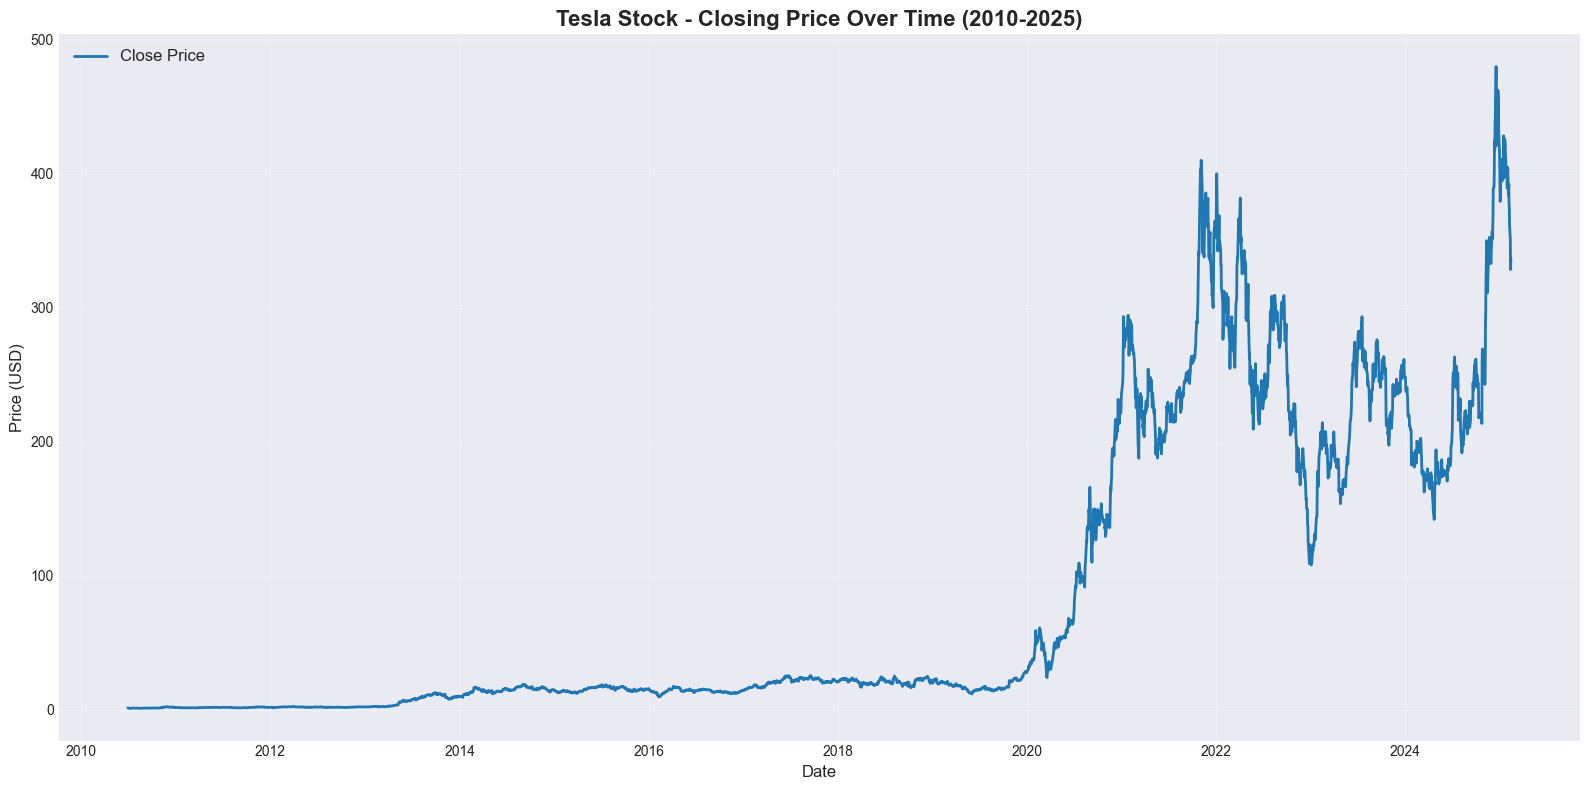

Initial Price (2010): $1.59
Final Price (2025): $336.51
Total Change: $334.92
Percentage Change: 21028.71%


In [9]:
# Graph 1: Closing Price Over Time
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2, color='#1f77b4')
plt.title('Tesla Stock - Closing Price Over Time (2010-2025)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial Price (2010): ${df['Close'].iloc[0]:.2f}")
print(f"Final Price (2025): ${df['Close'].iloc[-1]:.2f}")
print(f"Total Change: ${df['Close'].iloc[-1] - df['Close'].iloc[0]:.2f}")
print(f"Percentage Change: {((df['Close'].iloc[-1] / df['Close'].iloc[0]) - 1) * 100:.2f}%")


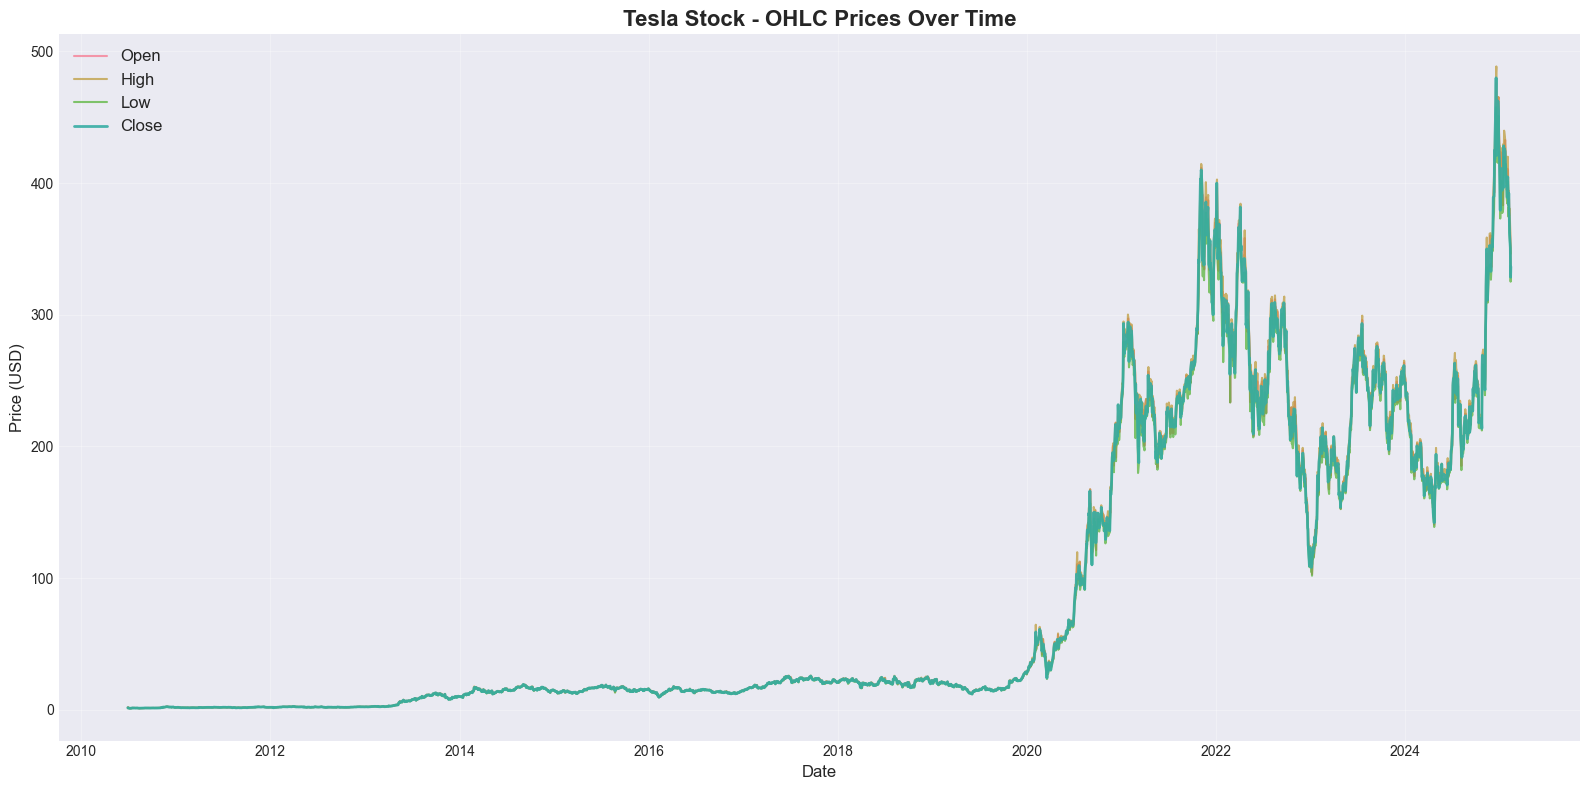

In [10]:
# Graph 2: Open, High, Low, Close Prices Over Time
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Open'], label='Open', alpha=0.7, linewidth=1.5)
plt.plot(df.index, df['High'], label='High', alpha=0.7, linewidth=1.5)
plt.plot(df.index, df['Low'], label='Low', alpha=0.7, linewidth=1.5)
plt.plot(df.index, df['Close'], label='Close', alpha=0.9, linewidth=2)
plt.title('Tesla Stock - OHLC Prices Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


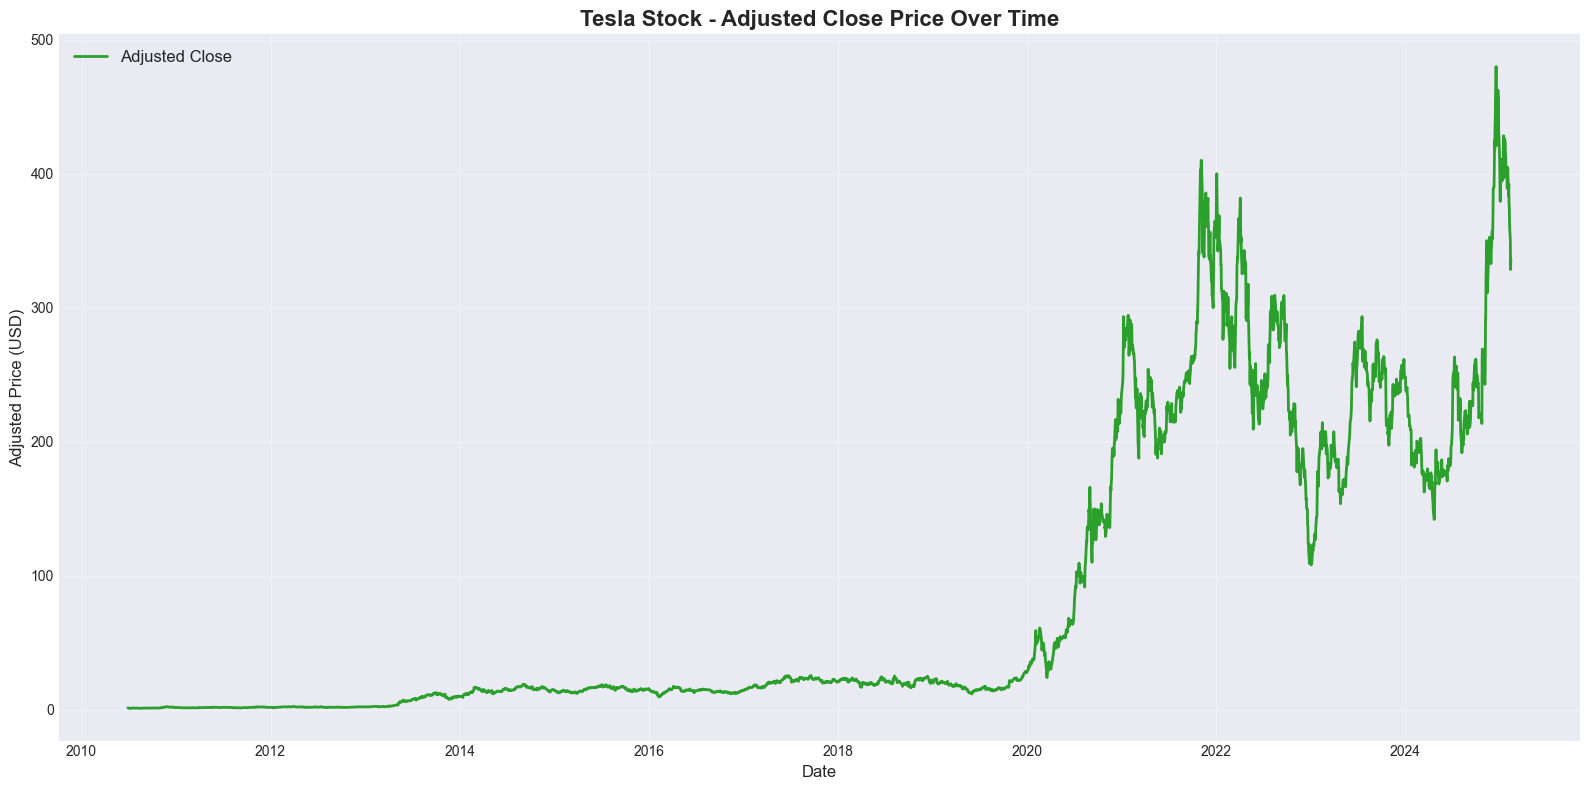

In [11]:
# Graph 3: Adjusted Close Price Over Time
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Adj Close'], label='Adjusted Close', linewidth=2, color='#2ca02c')
plt.title('Tesla Stock - Adjusted Close Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


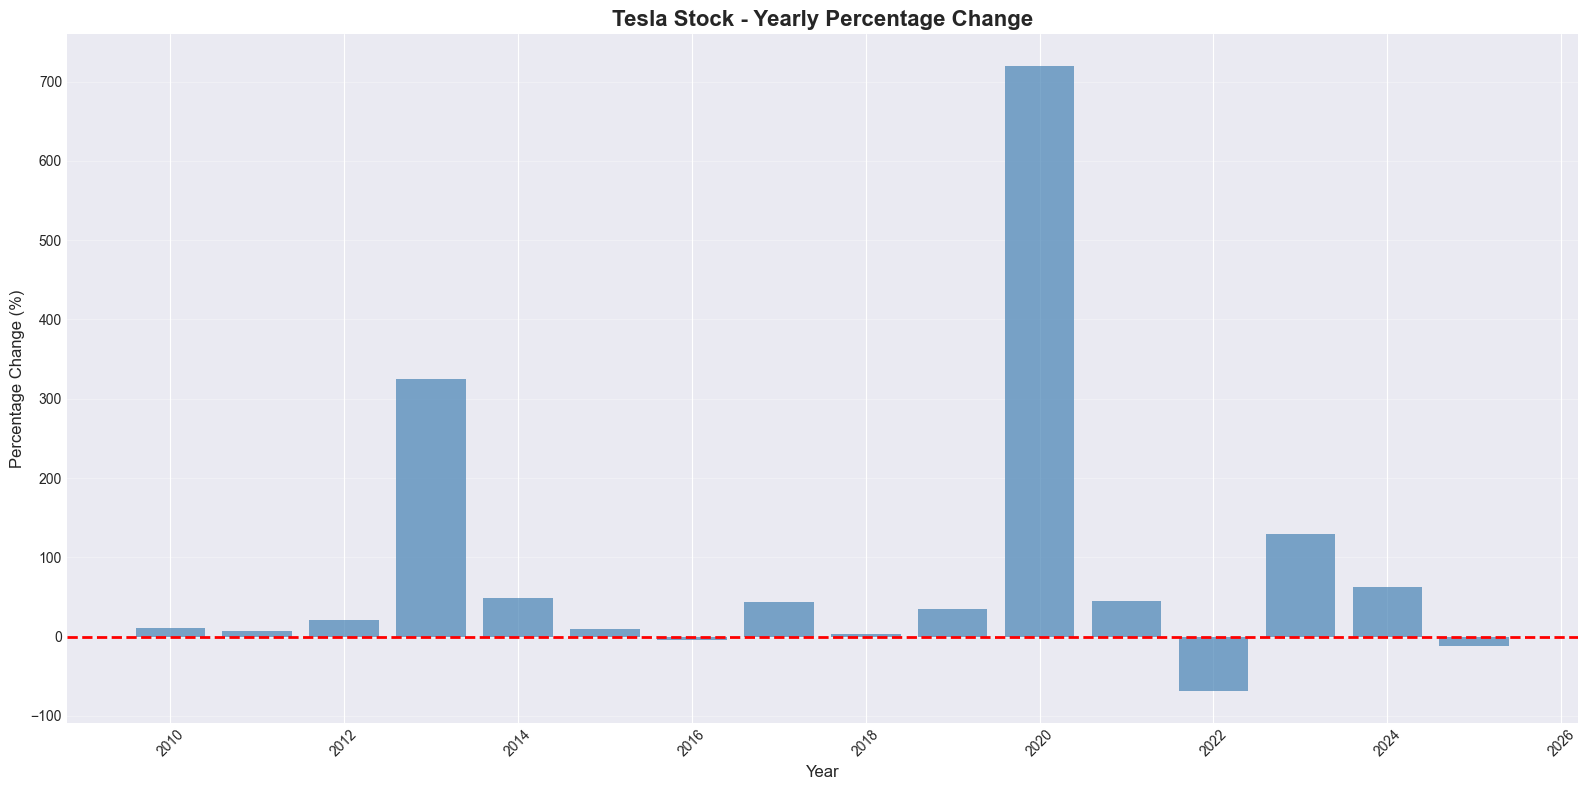

Yearly Change Statistics:
      Yearly_Change
Year               
2010      11.469194
2011       7.287734
2012      20.619654
2013     325.424311
2014      48.174545
2015       9.438694
2016      -4.350744
2017      43.485876
2018       3.828029
2019      34.892938
2020     720.050647
2021      44.810012
2022     -69.199353
2023     129.861239
2024      62.563400
2025     -11.276627


In [12]:
# Graph 4: Yearly Price Change Analysis
df['Year'] = df.index.year
yearly_stats = df.groupby('Year')['Close'].agg(['first', 'last', 'min', 'max', 'mean'])
yearly_stats['Yearly_Change'] = ((yearly_stats['last'] - yearly_stats['first']) / yearly_stats['first']) * 100

plt.figure(figsize=(16, 8))
plt.bar(yearly_stats.index, yearly_stats['Yearly_Change'], color='steelblue', alpha=0.7)
plt.title('Tesla Stock - Yearly Percentage Change', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage Change (%)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Yearly Change Statistics:")
print(yearly_stats[['Yearly_Change']])


### Question 2: What was the daily return of the stock on average?


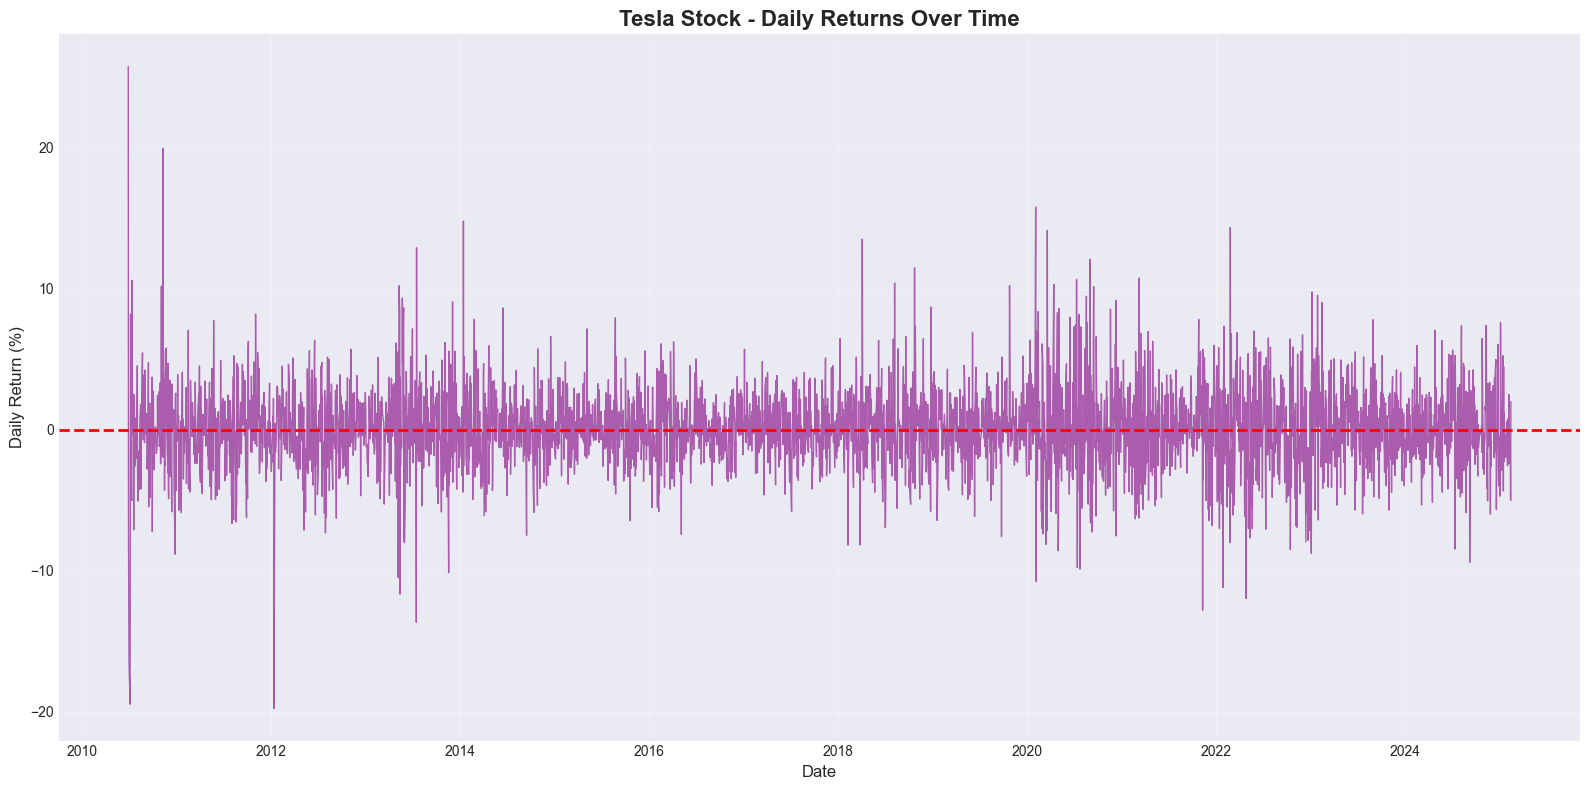

Average Daily Return: 0.0281%
Median Daily Return: -0.0122%
Standard Deviation: 2.9426%
Maximum Daily Return: 25.7368%
Minimum Daily Return: -19.7535%


In [13]:
# Graph 5: Daily Returns Over Time
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Daily Return'], alpha=0.6, linewidth=1, color='purple')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Tesla Stock - Daily Returns Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Return (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average Daily Return: {df['Daily Return'].mean():.4f}%")
print(f"Median Daily Return: {df['Daily Return'].median():.4f}%")
print(f"Standard Deviation: {df['Daily Return'].std():.4f}%")
print(f"Maximum Daily Return: {df['Daily Return'].max():.4f}%")
print(f"Minimum Daily Return: {df['Daily Return'].min():.4f}%")


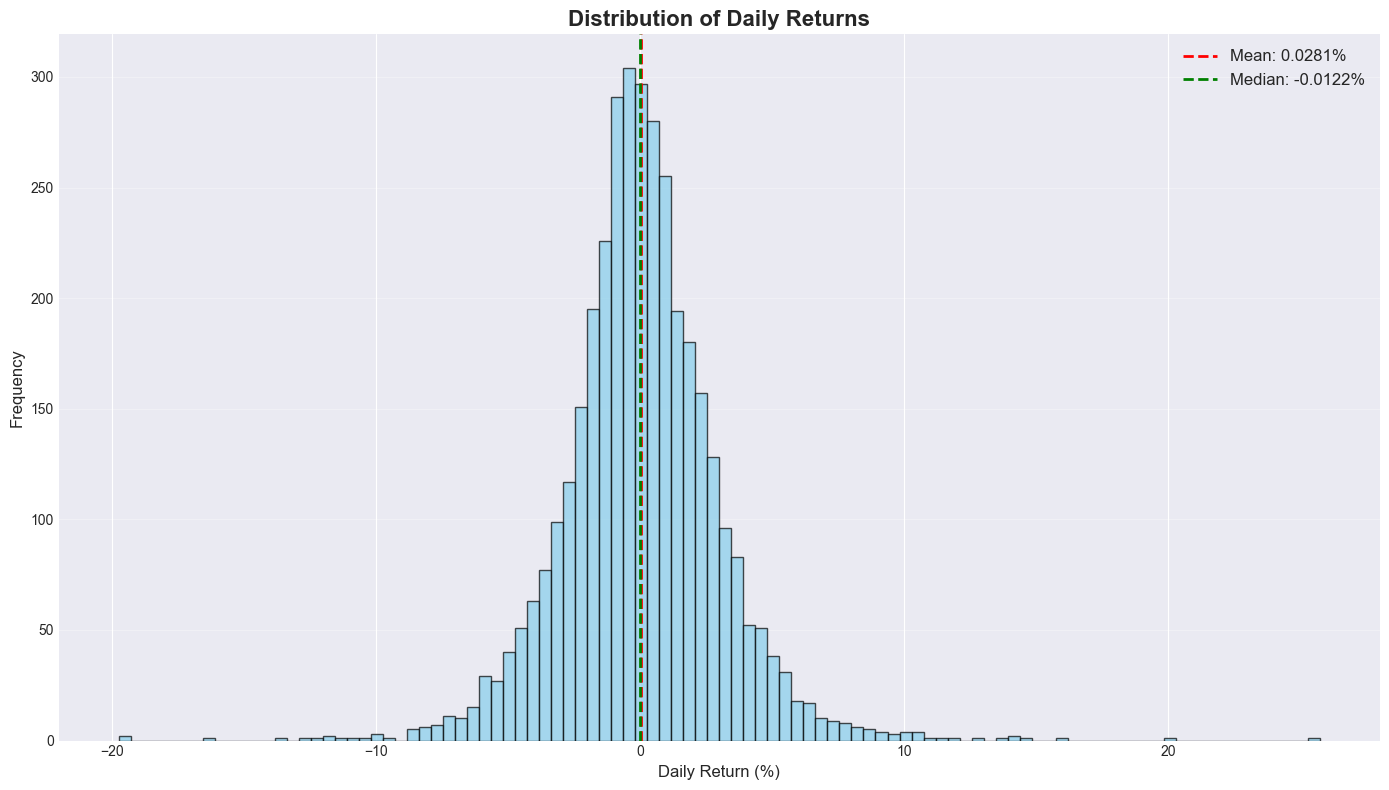

In [14]:
# Graph 6: Distribution of Daily Returns (Histogram)
plt.figure(figsize=(14, 8))
plt.hist(df['Daily Return'].dropna(), bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=df['Daily Return'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Daily Return"].mean():.4f}%')
plt.axvline(x=df['Daily Return'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["Daily Return"].median():.4f}%')
plt.title('Distribution of Daily Returns', fontsize=16, fontweight='bold')
plt.xlabel('Daily Return (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


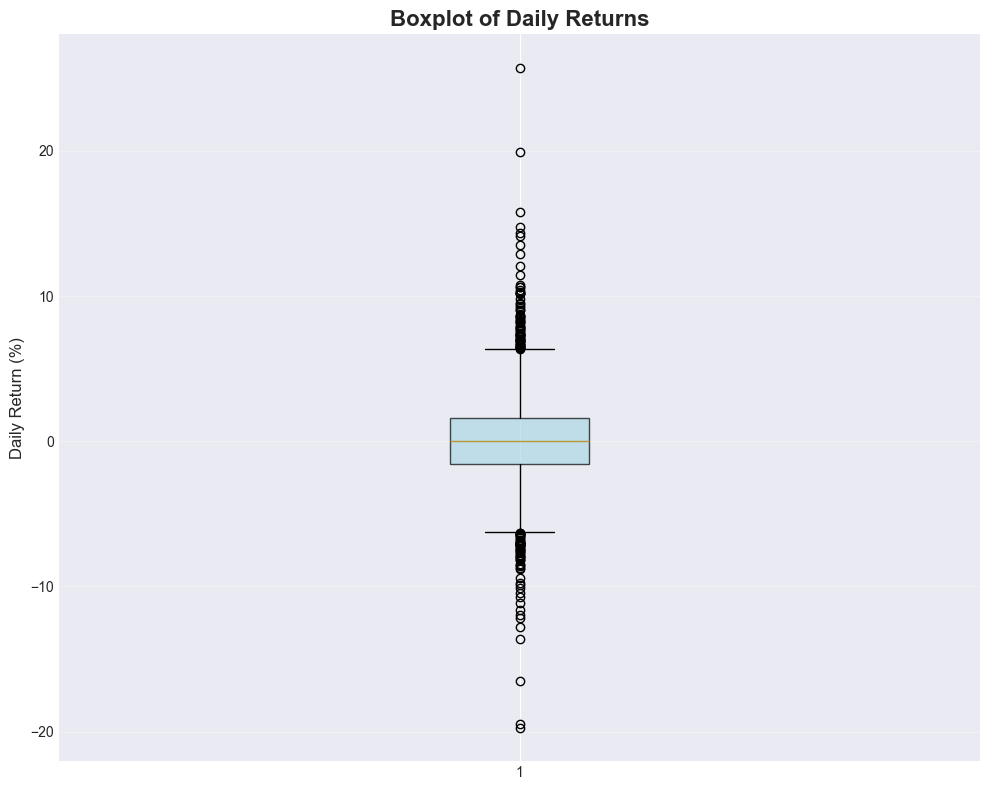

Number of outliers in Daily Returns: 136


In [15]:
# Graph 7: Boxplot of Daily Returns
plt.figure(figsize=(10, 8))
plt.boxplot(df['Daily Return'].dropna(), vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.title('Boxplot of Daily Returns', fontsize=16, fontweight='bold')
plt.ylabel('Daily Return (%)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Calculate outliers
Q1 = df['Daily Return'].quantile(0.25)
Q3 = df['Daily Return'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Daily Return'] < Q1 - 1.5*IQR) | (df['Daily Return'] > Q3 + 1.5*IQR)]
print(f"Number of outliers in Daily Returns: {len(outliers)}")


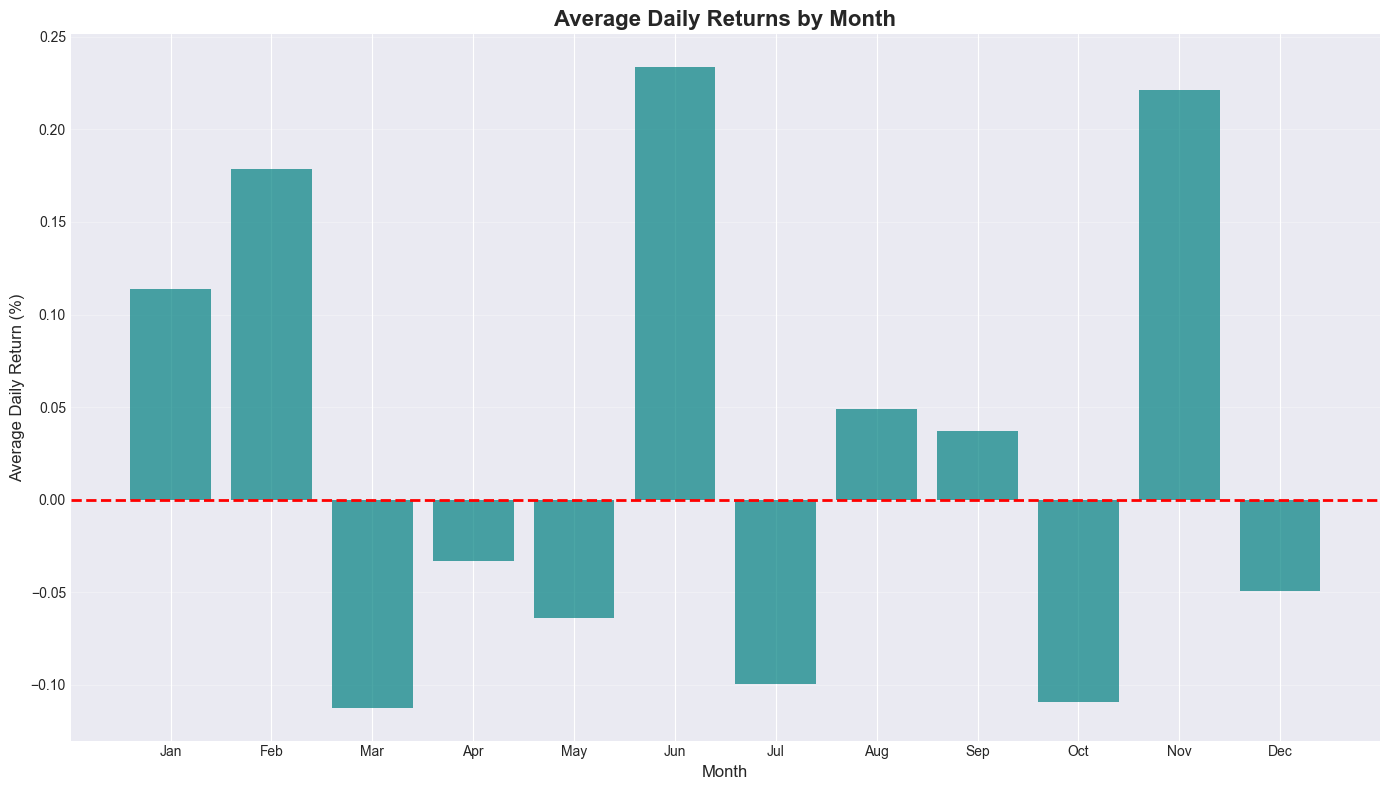

Monthly Average Returns:
Jan: 0.1136%
Feb: 0.1788%
Mar: -0.1128%
Apr: -0.0329%
May: -0.0640%
Jun: 0.2339%
Jul: -0.0995%
Aug: 0.0488%
Sep: 0.0373%
Oct: -0.1096%
Nov: 0.2213%
Dec: -0.0496%


In [16]:
# Graph 8: Monthly Average Returns
df['Month'] = df.index.month
monthly_returns = df.groupby('Month')['Daily Return'].mean()

plt.figure(figsize=(14, 8))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(months, monthly_returns.values, color='teal', alpha=0.7)
plt.title('Average Daily Returns by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Daily Return (%)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("Monthly Average Returns:")
for month, ret in zip(months, monthly_returns.values):
    print(f"{month}: {ret:.4f}%")


### Question 3: What was the moving average of the stock?


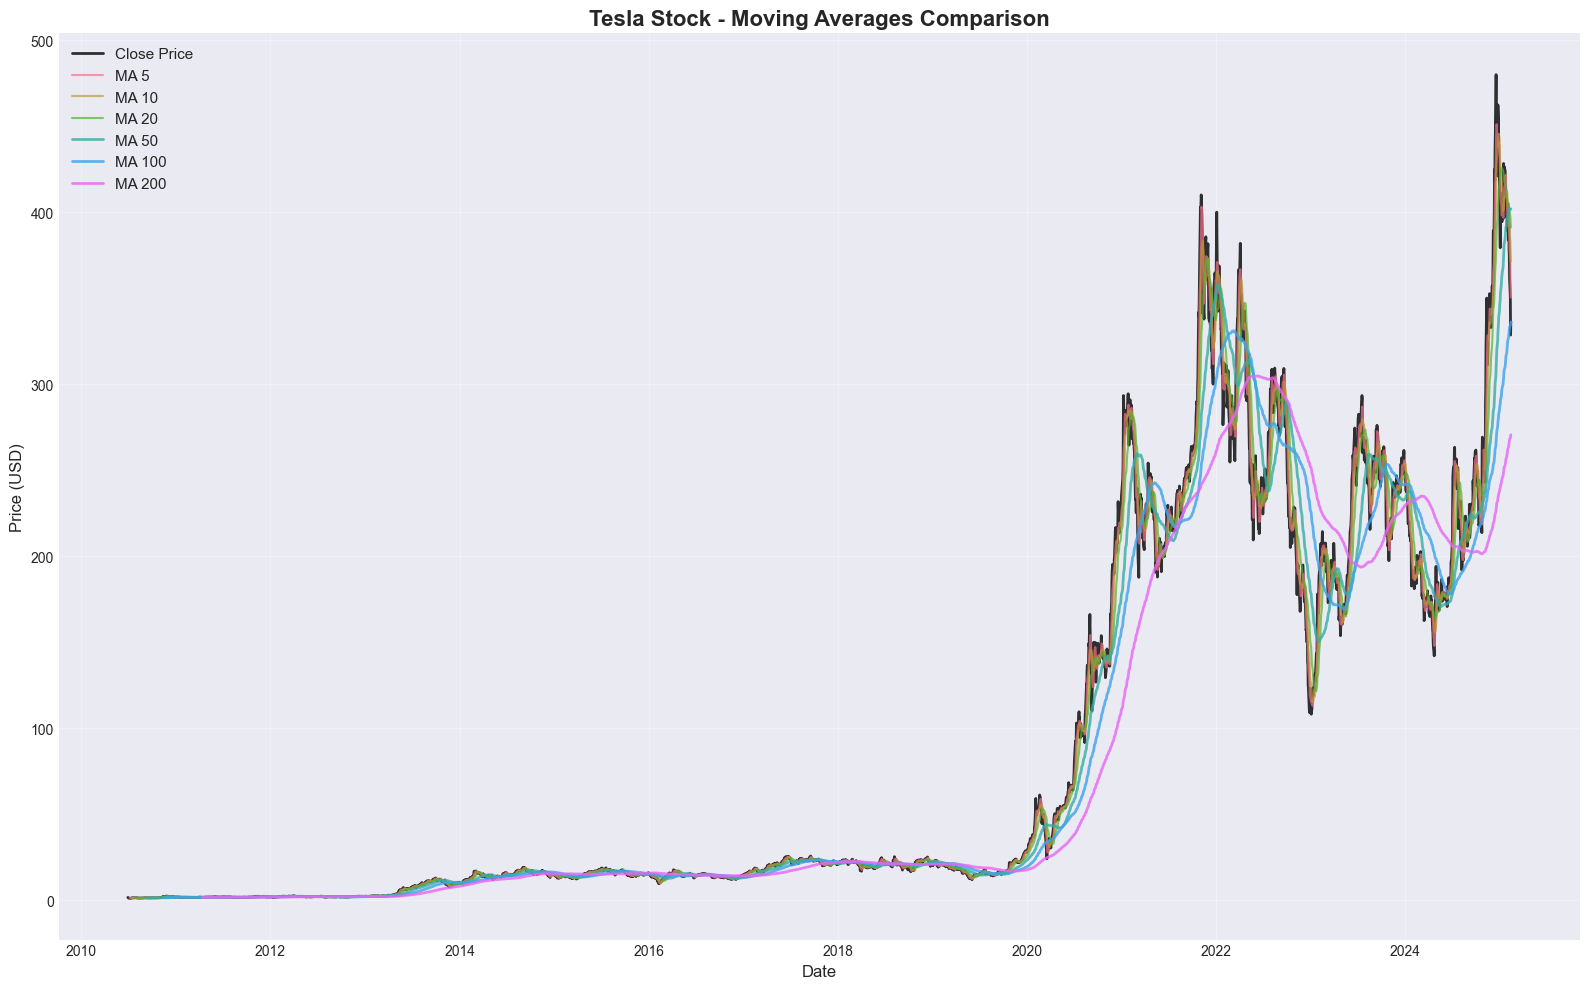

In [17]:
# Graph 9: Moving Averages Comparison
plt.figure(figsize=(16, 10))
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2, alpha=0.8, color='black')
plt.plot(df.index, df['MA_5'], label='MA 5', linewidth=1.5, alpha=0.7)
plt.plot(df.index, df['MA_10'], label='MA 10', linewidth=1.5, alpha=0.7)
plt.plot(df.index, df['MA_20'], label='MA 20', linewidth=1.5, alpha=0.7)
plt.plot(df.index, df['MA_50'], label='MA 50', linewidth=2, alpha=0.8)
plt.plot(df.index, df['MA_100'], label='MA 100', linewidth=2, alpha=0.8)
plt.plot(df.index, df['MA_200'], label='MA 200', linewidth=2, alpha=0.8)
plt.title('Tesla Stock - Moving Averages Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


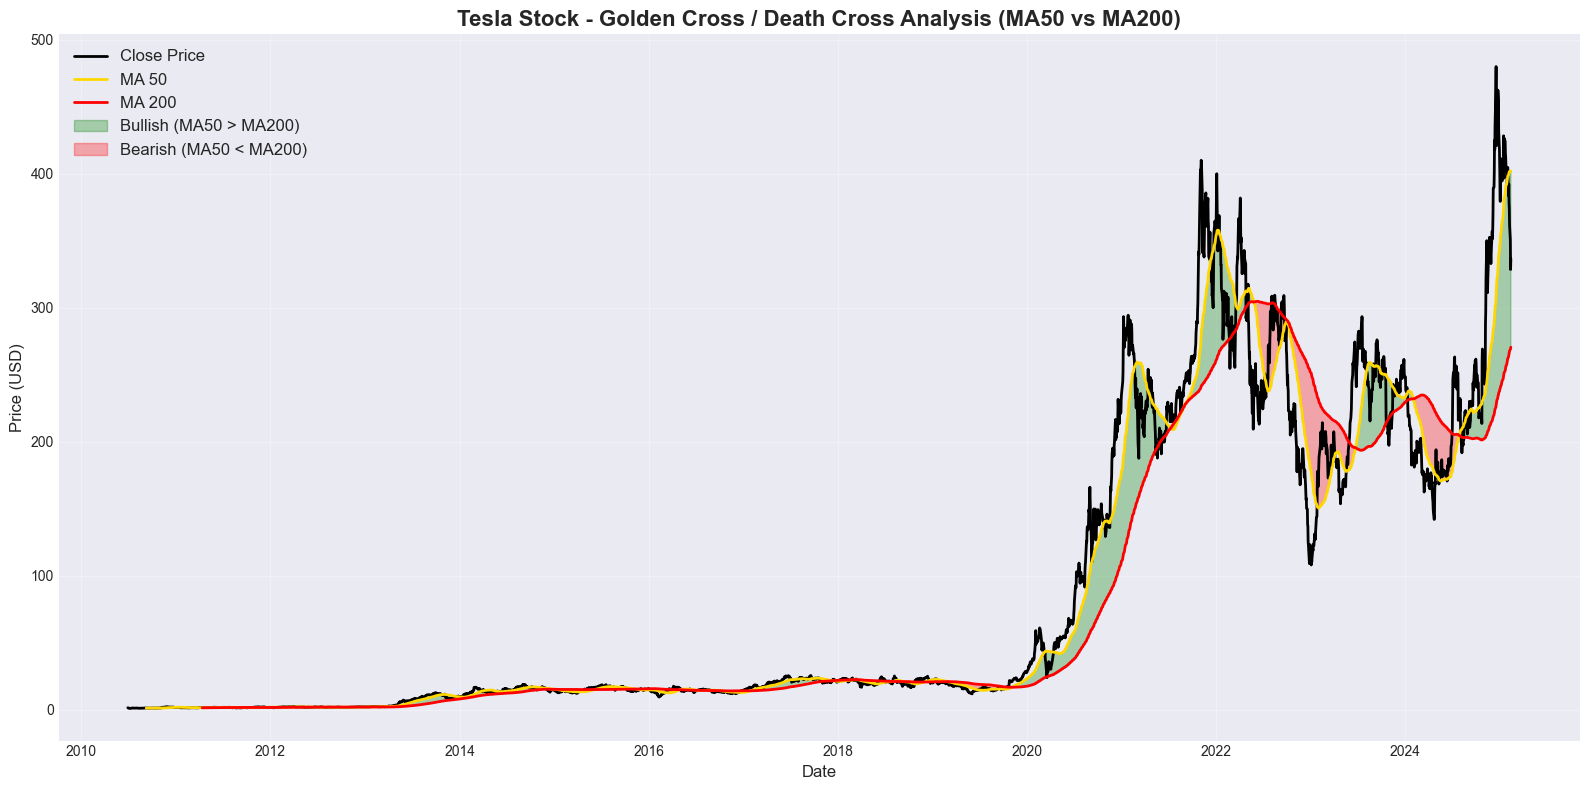

In [18]:
# Graph 10: Close Price with MA 50 and MA 200 (Golden/Death Cross)
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2, color='black')
plt.plot(df.index, df['MA_50'], label='MA 50', linewidth=2, color='gold')
plt.plot(df.index, df['MA_200'], label='MA 200', linewidth=2, color='red')
plt.fill_between(df.index, df['MA_50'], df['MA_200'], where=(df['MA_50'] >= df['MA_200']), 
                 alpha=0.3, color='green', label='Bullish (MA50 > MA200)')
plt.fill_between(df.index, df['MA_50'], df['MA_200'], where=(df['MA_50'] < df['MA_200']), 
                 alpha=0.3, color='red', label='Bearish (MA50 < MA200)')
plt.title('Tesla Stock - Golden Cross / Death Cross Analysis (MA50 vs MA200)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


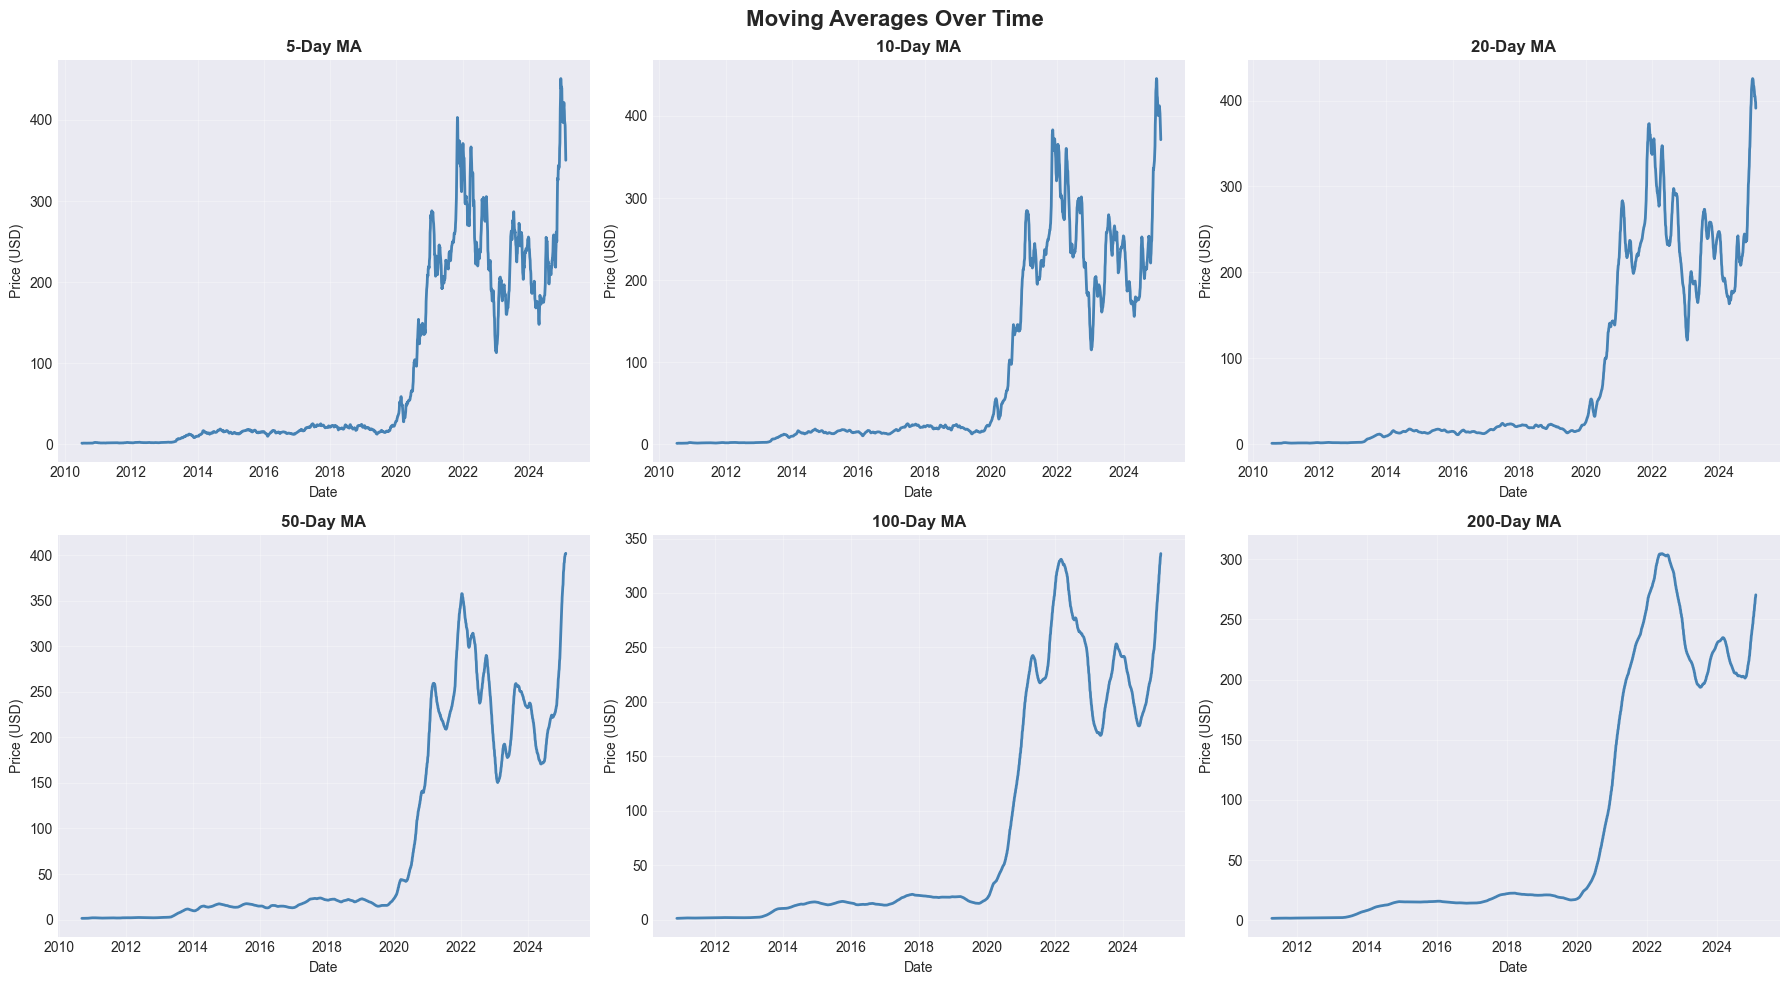

In [19]:
# Graph 11: Moving Average Values Over Time (Separate Plot)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Moving Averages Over Time', fontsize=16, fontweight='bold')

mas = [('MA_5', '5-Day MA'), ('MA_10', '10-Day MA'), ('MA_20', '20-Day MA'),
       ('MA_50', '50-Day MA'), ('MA_100', '100-Day MA'), ('MA_200', '200-Day MA')]

for idx, (ma_col, ma_name) in enumerate(mas):
    ax = axes[idx // 3, idx % 3]
    ax.plot(df.index, df[ma_col], linewidth=2, color='steelblue')
    ax.set_title(ma_name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Price (USD)', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Question 4: What was the correlation between different features?


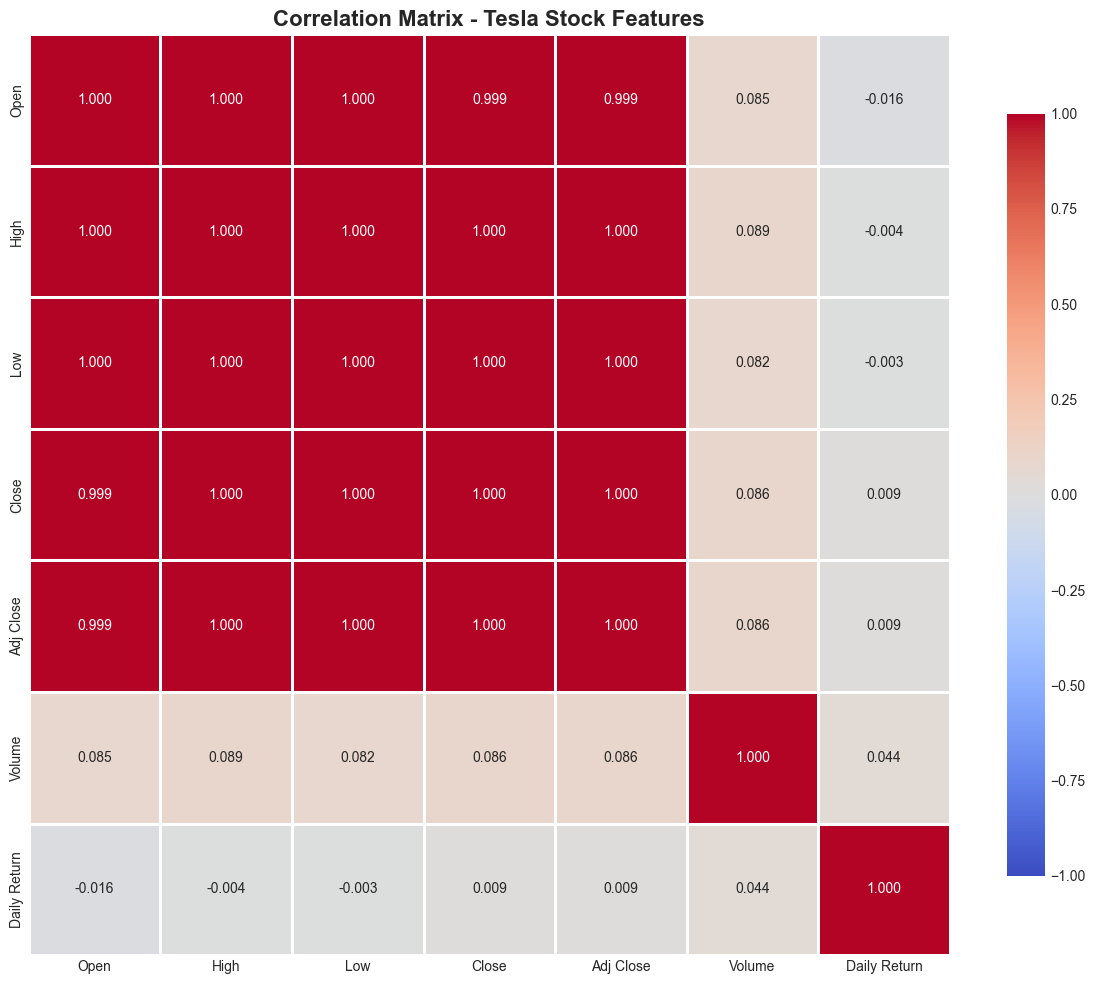

Correlation Matrix:
                  Open      High       Low     Close  Adj Close    Volume  \
Open          1.000000  0.999720  0.999628  0.999219   0.999219  0.085078   
High          0.999720  1.000000  0.999638  0.999646   0.999646  0.088642   
Low           0.999628  0.999638  1.000000  0.999689   0.999689  0.081985   
Close         0.999219  0.999646  0.999689  1.000000   1.000000  0.086060   
Adj Close     0.999219  0.999646  0.999689  1.000000   1.000000  0.086060   
Volume        0.085078  0.088642  0.081985  0.086060   0.086060  1.000000   
Daily Return -0.015672 -0.003836 -0.002719  0.009152   0.009152  0.043720   

              Daily Return  
Open             -0.015672  
High             -0.003836  
Low              -0.002719  
Close             0.009152  
Adj Close         0.009152  
Volume            0.043720  
Daily Return      1.000000  


In [20]:
# Graph 12: Correlation Heatmap
correlation_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily Return']
corr_matrix = df[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix - Tesla Stock Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(corr_matrix)


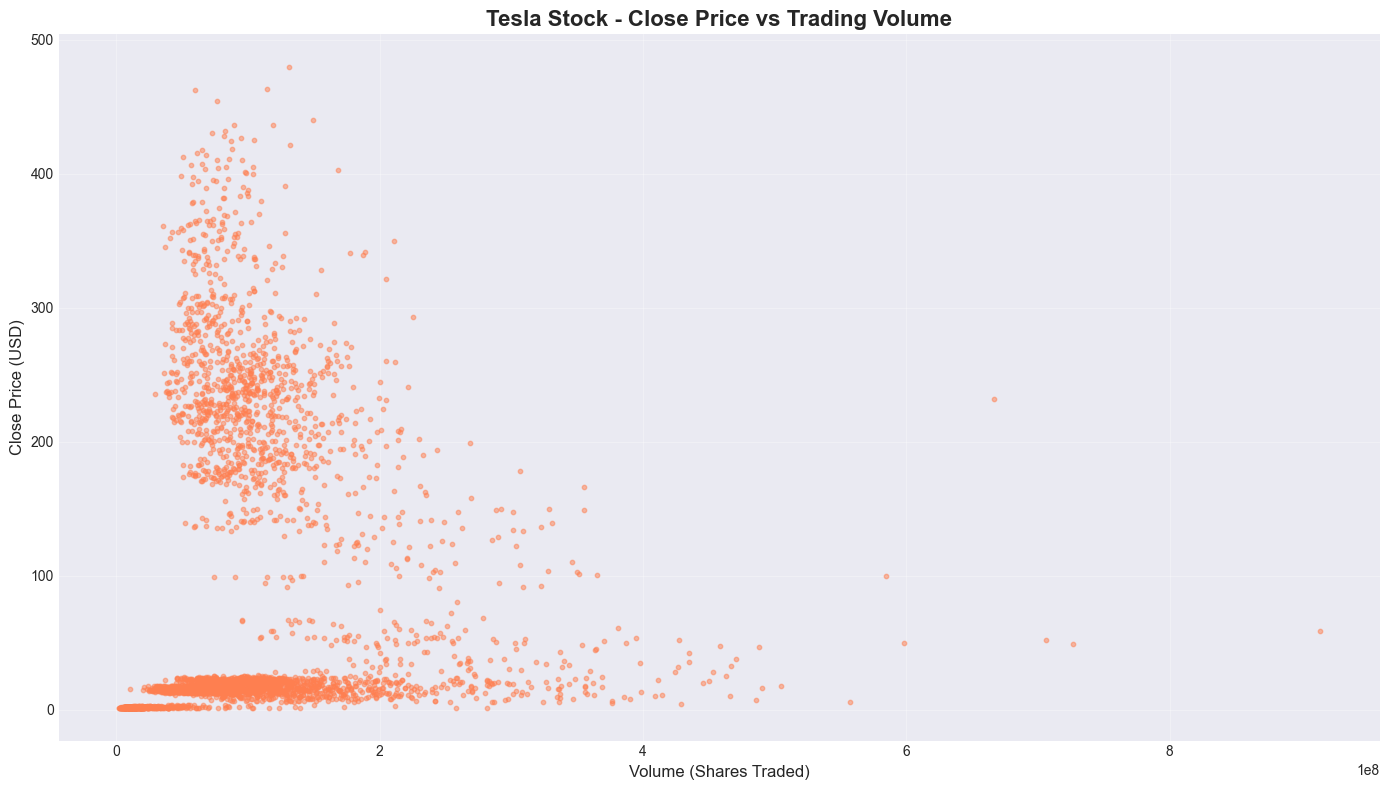

Correlation between Volume and Close Price: 0.0861


In [21]:
# Graph 13: Scatter Plot - Close vs Volume
plt.figure(figsize=(14, 8))
plt.scatter(df['Volume'], df['Close'], alpha=0.5, s=10, color='coral')
plt.title('Tesla Stock - Close Price vs Trading Volume', fontsize=16, fontweight='bold')
plt.xlabel('Volume (Shares Traded)', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

correlation_vol_close = df['Volume'].corr(df['Close'])
print(f"Correlation between Volume and Close Price: {correlation_vol_close:.4f}")


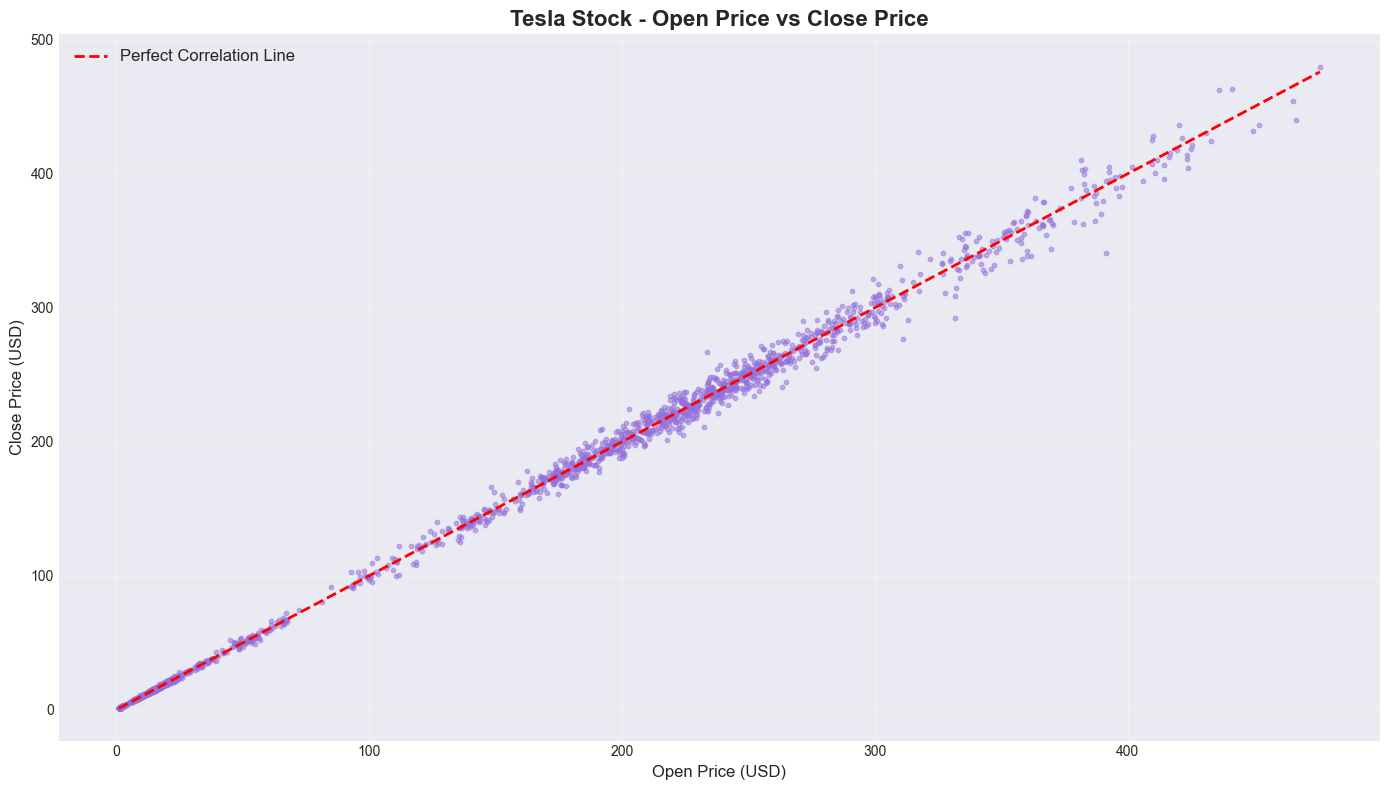

Correlation between Open and Close Price: 0.9992


In [22]:
# Graph 14: Scatter Plot - Open vs Close
plt.figure(figsize=(14, 8))
plt.scatter(df['Open'], df['Close'], alpha=0.5, s=10, color='mediumpurple')
plt.plot([df['Open'].min(), df['Open'].max()], [df['Open'].min(), df['Open'].max()], 
         'r--', linewidth=2, label='Perfect Correlation Line')
plt.title('Tesla Stock - Open Price vs Close Price', fontsize=16, fontweight='bold')
plt.xlabel('Open Price (USD)', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

correlation_open_close = df['Open'].corr(df['Close'])
print(f"Correlation between Open and Close Price: {correlation_open_close:.4f}")


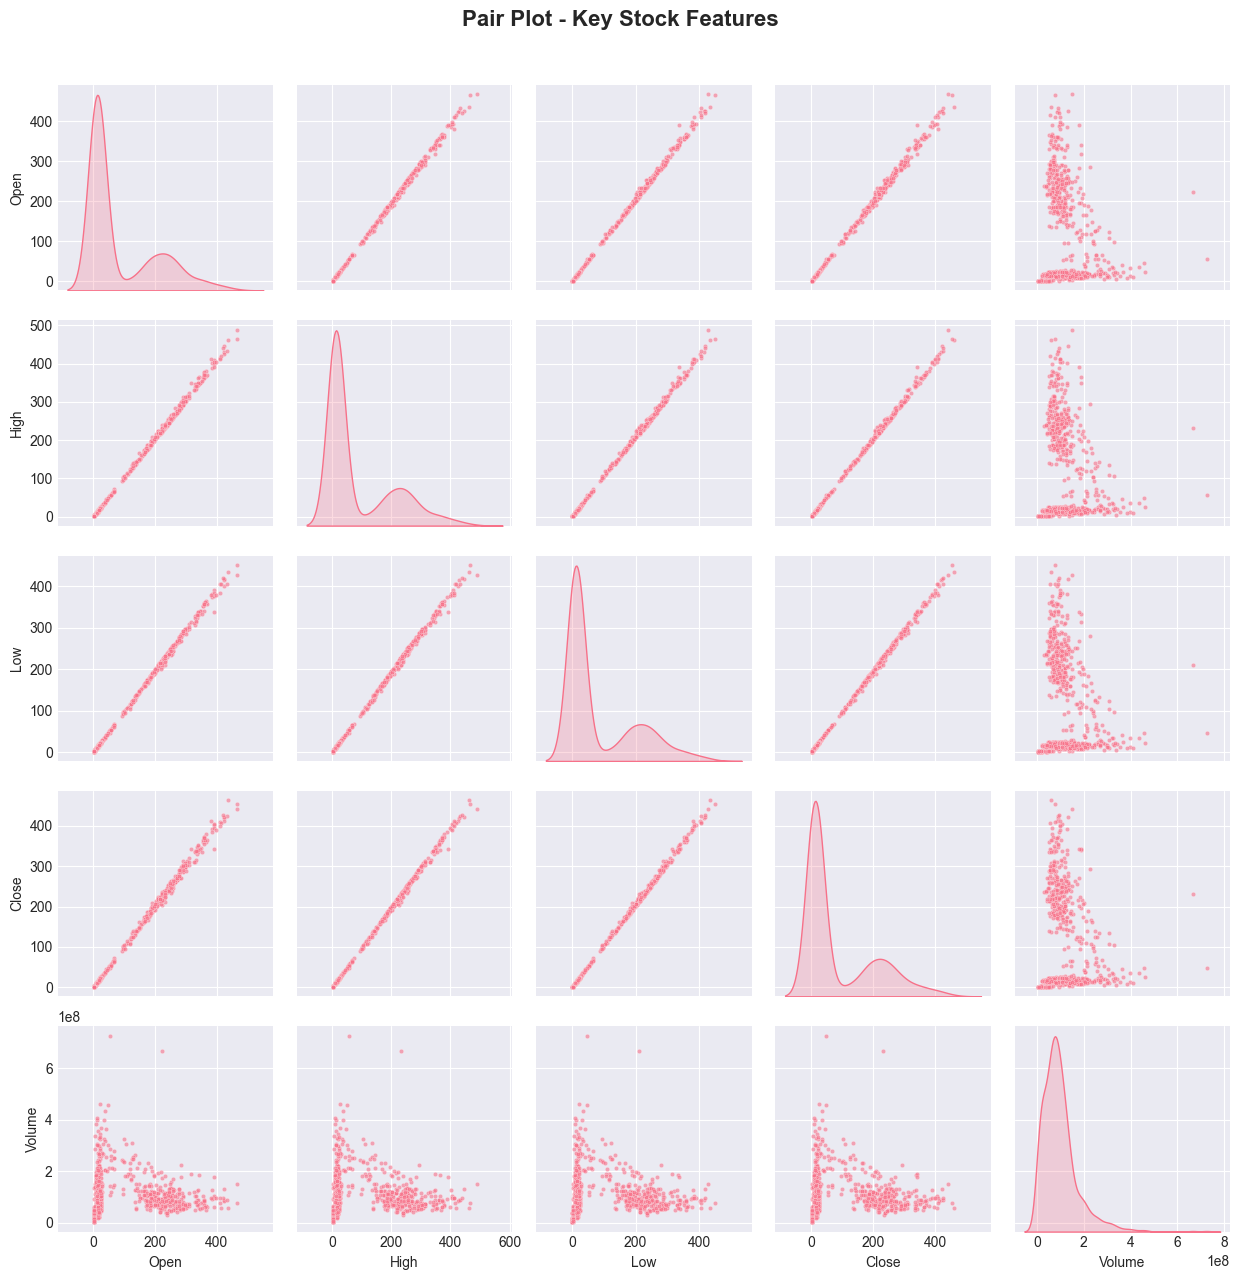

In [23]:
# Graph 15: Pair Plot of Key Features
key_features = ['Open', 'High', 'Low', 'Close', 'Volume']
sns.pairplot(df[key_features].sample(min(1000, len(df))), diag_kind='kde', 
             plot_kws={'alpha': 0.6, 's': 10})
plt.suptitle('Pair Plot - Key Stock Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### Question 5: How much value do we put at risk by investing in this stock?


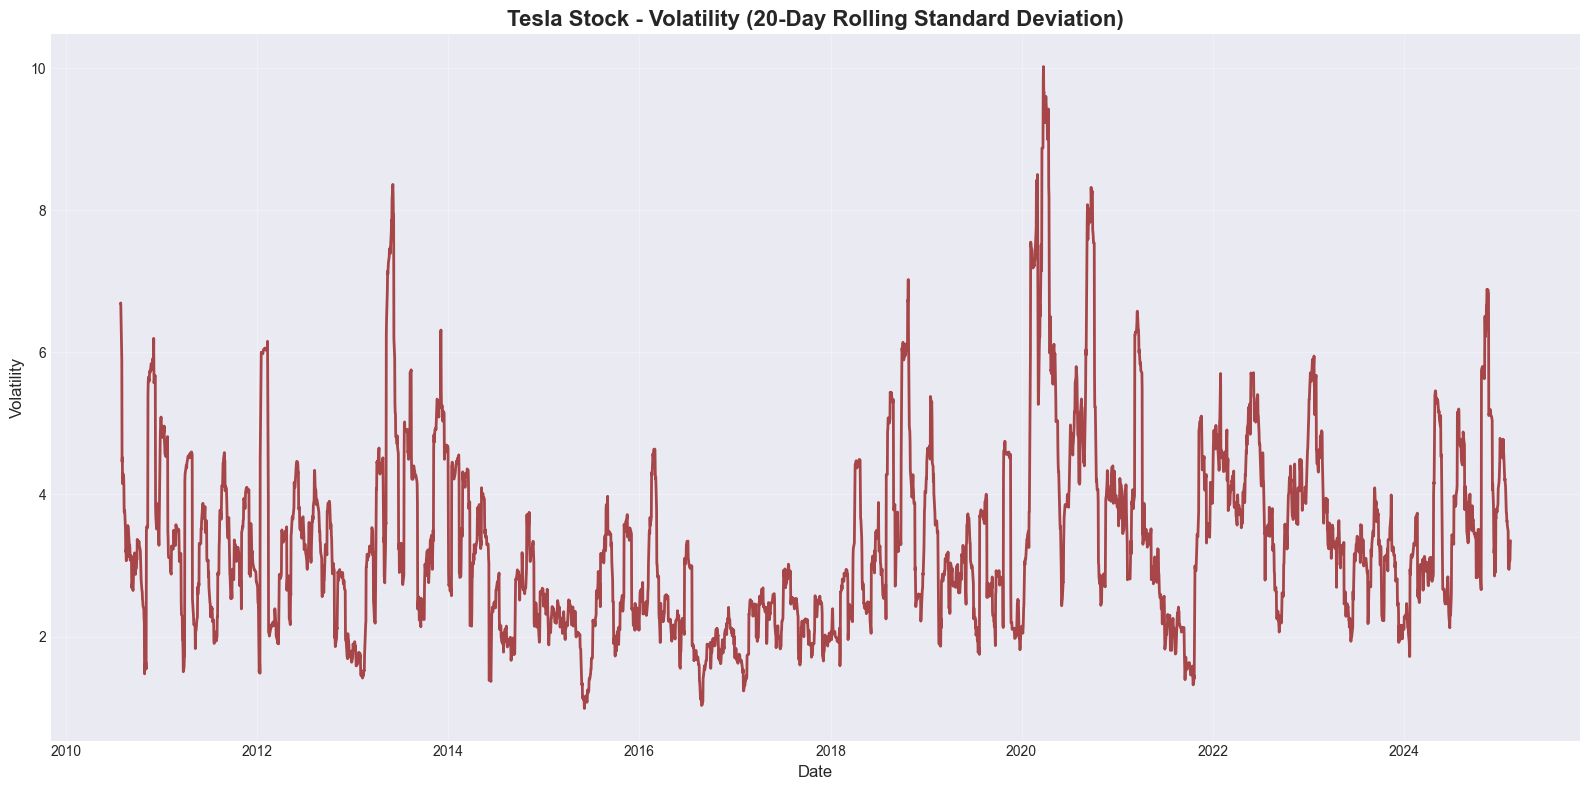

Average Volatility: 3.3318
Maximum Volatility: 10.0268
Minimum Volatility: 0.9862


In [24]:
# Graph 16: Volatility Over Time
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Volatility'], linewidth=2, color='darkred', alpha=0.7)
plt.title('Tesla Stock - Volatility (20-Day Rolling Standard Deviation)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average Volatility: {df['Volatility'].mean():.4f}")
print(f"Maximum Volatility: {df['Volatility'].max():.4f}")
print(f"Minimum Volatility: {df['Volatility'].min():.4f}")


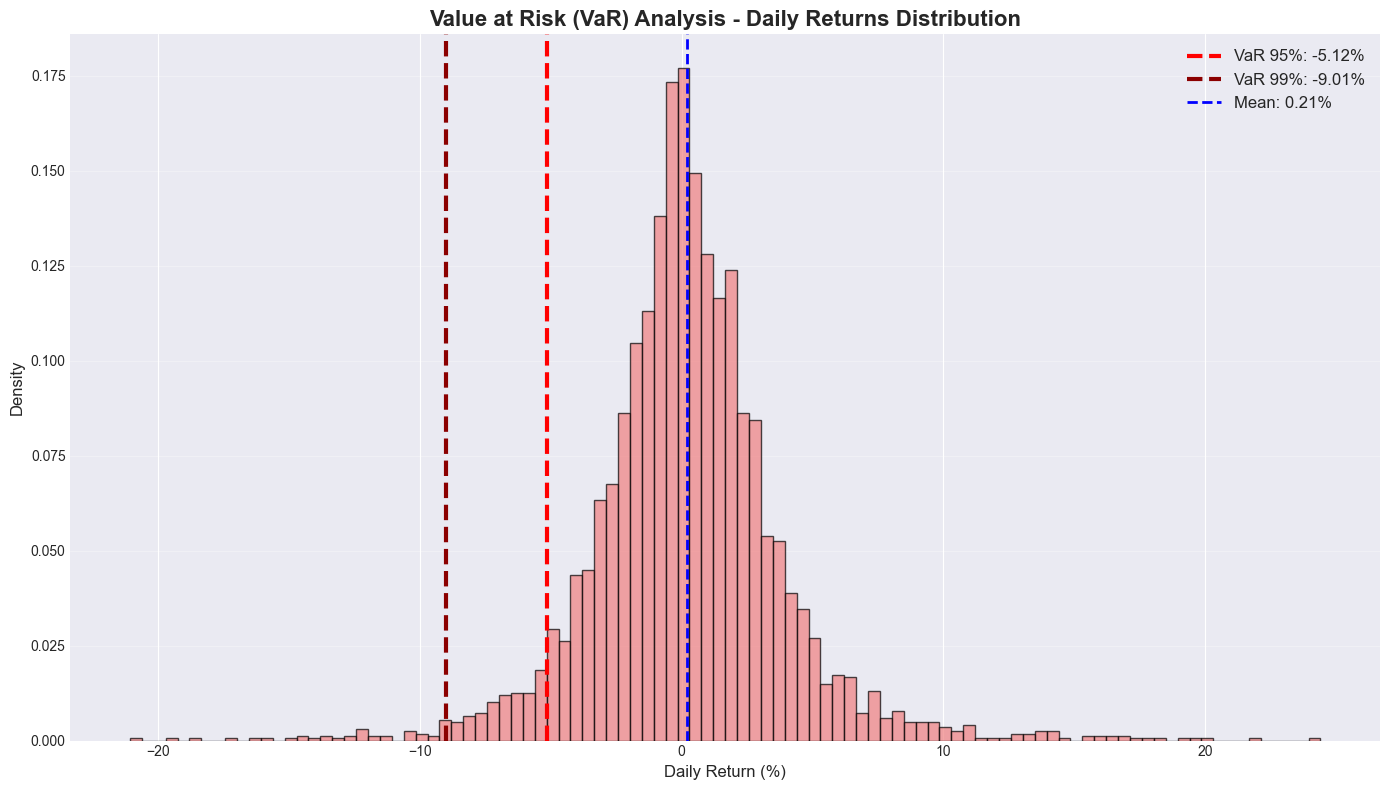

Value at Risk (95% confidence): -5.1240%
Value at Risk (99% confidence): -9.0110%
This means:
  - 95% of the time, losses won't exceed 5.12%
  - 99% of the time, losses won't exceed 9.01%


In [25]:
# Graph 17: Value at Risk (VaR) Analysis
# Calculate VaR at 95% confidence level
returns = df['Percent Change'].dropna()
VaR_95 = np.percentile(returns, 5)  # 5th percentile (95% VaR)
VaR_99 = np.percentile(returns, 1)  # 1st percentile (99% VaR)

plt.figure(figsize=(14, 8))
plt.hist(returns, bins=100, color='lightcoral', edgecolor='black', alpha=0.7, density=True)
plt.axvline(x=VaR_95, color='red', linestyle='--', linewidth=3, label=f'VaR 95%: {VaR_95:.2f}%')
plt.axvline(x=VaR_99, color='darkred', linestyle='--', linewidth=3, label=f'VaR 99%: {VaR_99:.2f}%')
plt.axvline(x=returns.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {returns.mean():.2f}%')
plt.title('Value at Risk (VaR) Analysis - Daily Returns Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Daily Return (%)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Value at Risk (95% confidence): {VaR_95:.4f}%")
print(f"Value at Risk (99% confidence): {VaR_99:.4f}%")
print(f"This means:")
print(f"  - 95% of the time, losses won't exceed {abs(VaR_95):.2f}%")
print(f"  - 99% of the time, losses won't exceed {abs(VaR_99):.2f}%")


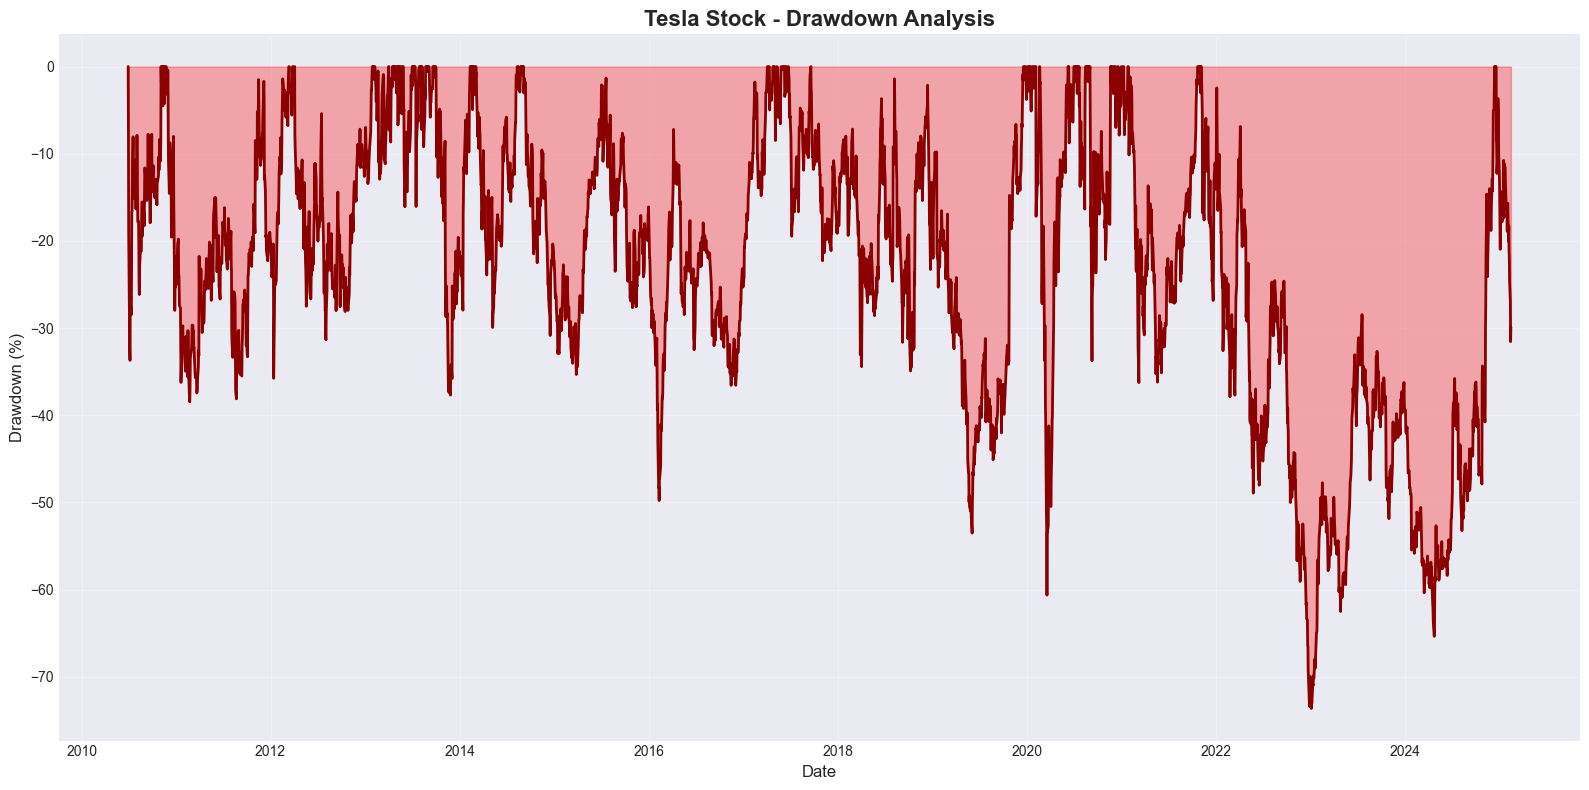

Maximum Drawdown: -73.63%
This represents the largest peak-to-trough decline in the stock price.


In [26]:
# Graph 18: Maximum Drawdown Analysis
df['Cumulative Return'] = (1 + df['Percent Change']/100).cumprod()
df['Running Max'] = df['Cumulative Return'].expanding().max()
df['Drawdown'] = (df['Cumulative Return'] - df['Running Max']) / df['Running Max'] * 100

plt.figure(figsize=(16, 8))
plt.fill_between(df.index, df['Drawdown'], 0, color='red', alpha=0.3)
plt.plot(df.index, df['Drawdown'], linewidth=2, color='darkred')
plt.title('Tesla Stock - Drawdown Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Drawdown (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

max_drawdown = df['Drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"This represents the largest peak-to-trough decline in the stock price.")


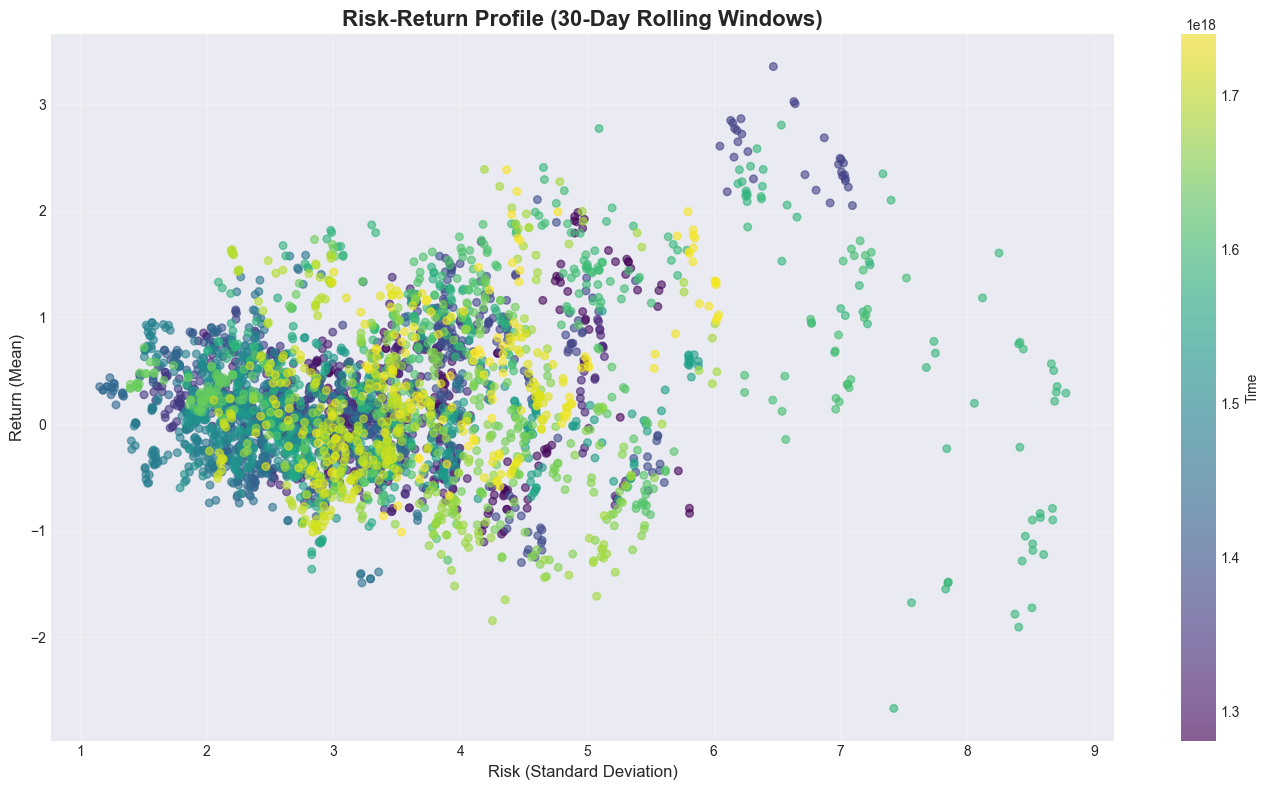

Annualized Sharpe Ratio: 0.9245
Higher Sharpe ratio indicates better risk-adjusted returns.


In [27]:
# Graph 19: Risk-Return Scatter (Rolling 30-day windows)
rolling_return = df['Percent Change'].rolling(window=30).mean()
rolling_risk = df['Percent Change'].rolling(window=30).std()

plt.figure(figsize=(14, 8))
plt.scatter(rolling_risk, rolling_return, alpha=0.6, s=30, c=df.index.astype(np.int64), cmap='viridis')
plt.colorbar(label='Time')
plt.xlabel('Risk (Standard Deviation)', fontsize=12)
plt.ylabel('Return (Mean)', fontsize=12)
plt.title('Risk-Return Profile (30-Day Rolling Windows)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

sharpe_ratio = (df['Percent Change'].mean() / df['Percent Change'].std()) * np.sqrt(252)
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Higher Sharpe ratio indicates better risk-adjusted returns.")


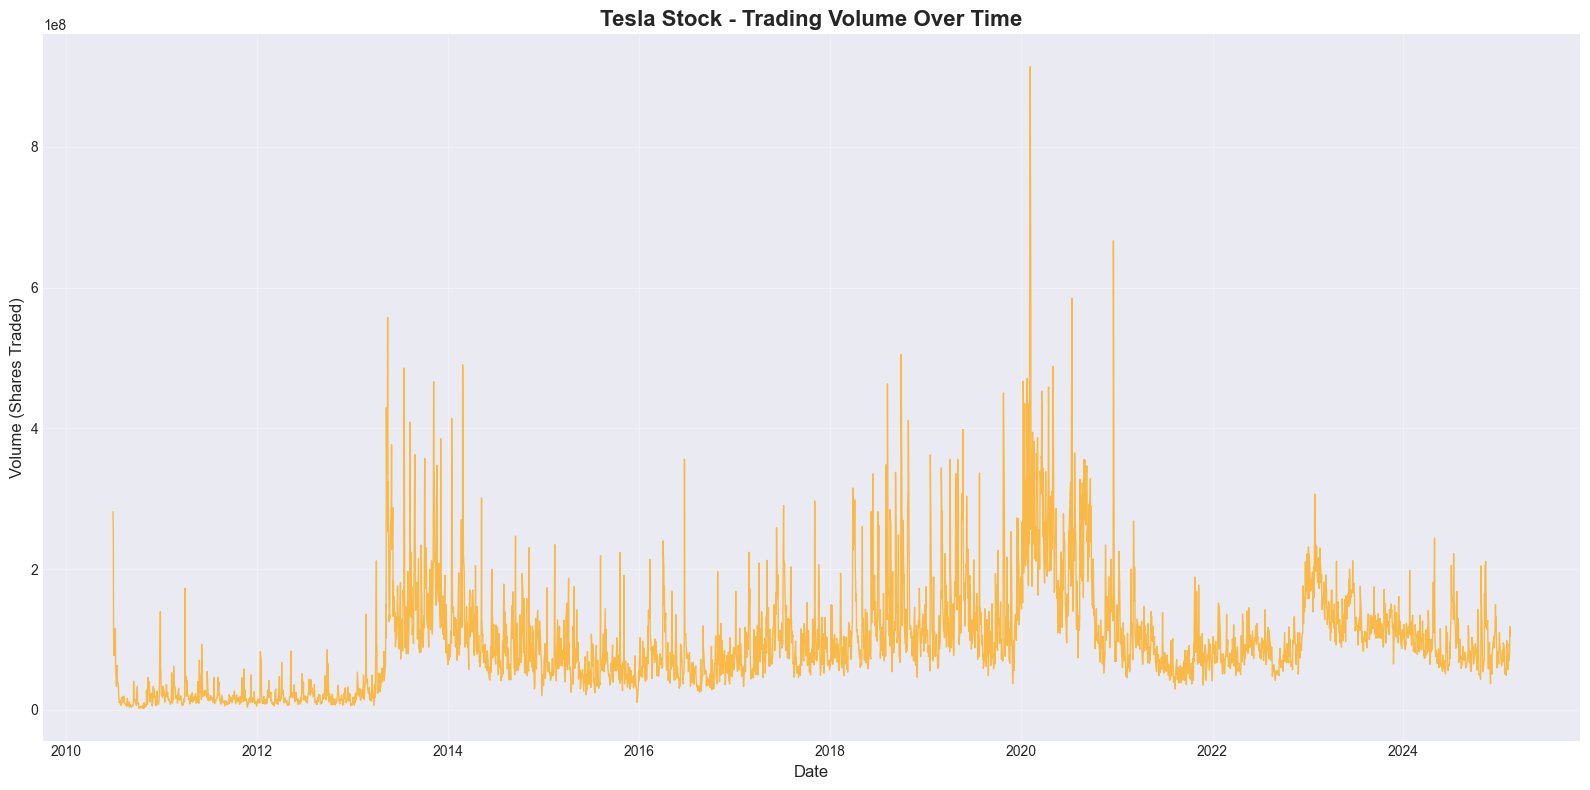

Average Daily Volume: 96,528,626 shares
Maximum Daily Volume: 914,082,000 shares
Minimum Daily Volume: 1,777,500 shares


In [28]:
# Graph 20: Trading Volume Over Time (Risk Indicator)
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Volume'], linewidth=1, alpha=0.7, color='orange')
plt.title('Tesla Stock - Trading Volume Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume (Shares Traded)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average Daily Volume: {df['Volume'].mean():,.0f} shares")
print(f"Maximum Daily Volume: {df['Volume'].max():,.0f} shares")
print(f"Minimum Daily Volume: {df['Volume'].min():,.0f} shares")


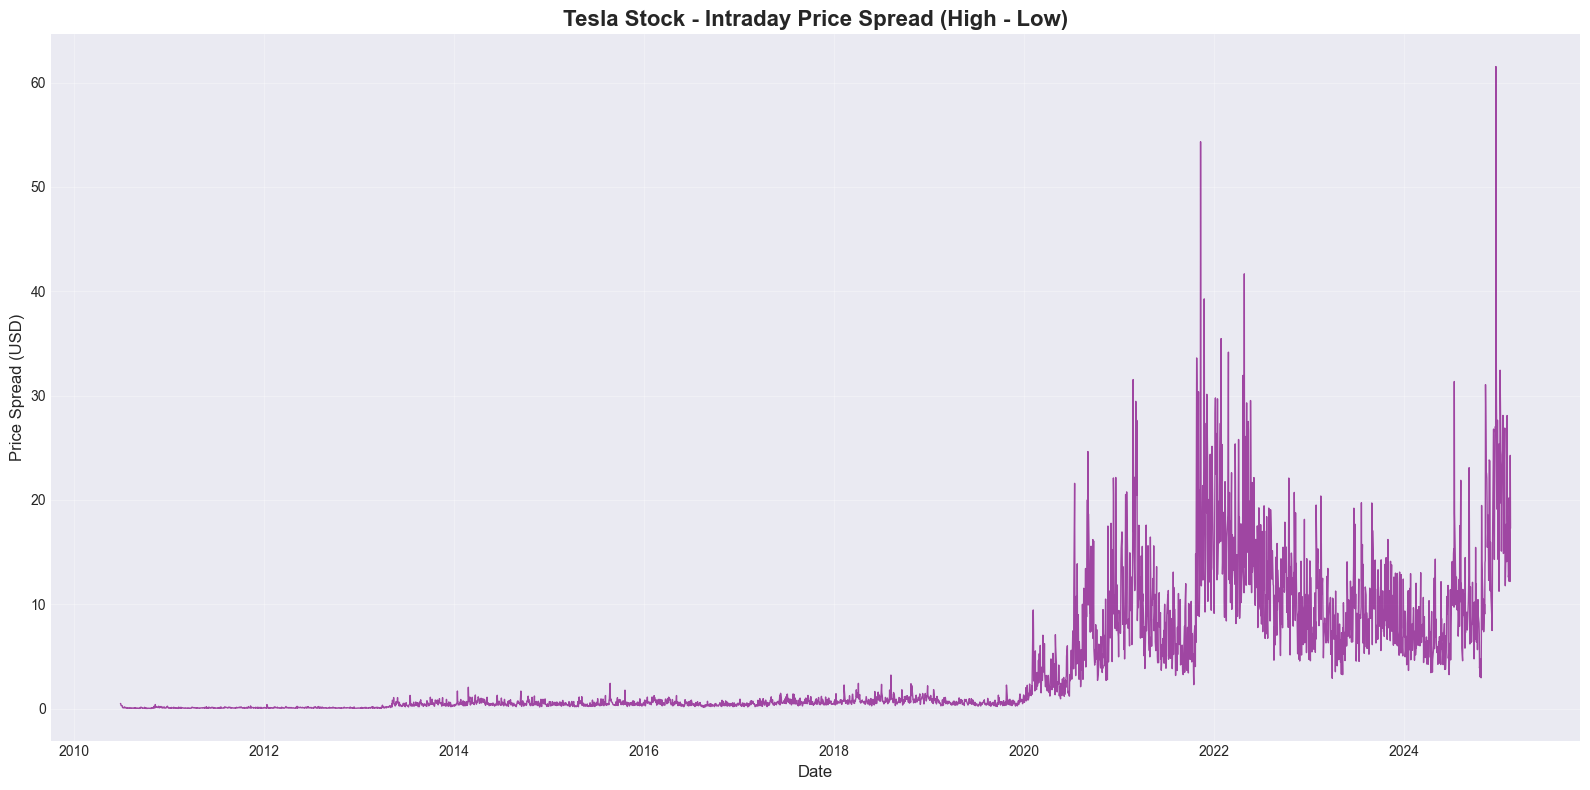

Average Intraday Spread: $3.82
Maximum Intraday Spread: $61.53
Minimum Intraday Spread: $0.02


In [29]:
# Graph 21: High-Low Spread (Intraday Volatility)
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['High-Low Spread'], linewidth=1, alpha=0.7, color='purple')
plt.title('Tesla Stock - Intraday Price Spread (High - Low)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price Spread (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average Intraday Spread: ${df['High-Low Spread'].mean():.2f}")
print(f"Maximum Intraday Spread: ${df['High-Low Spread'].max():.2f}")
print(f"Minimum Intraday Spread: ${df['High-Low Spread'].min():.2f}")


### Additional Analysis Graphs


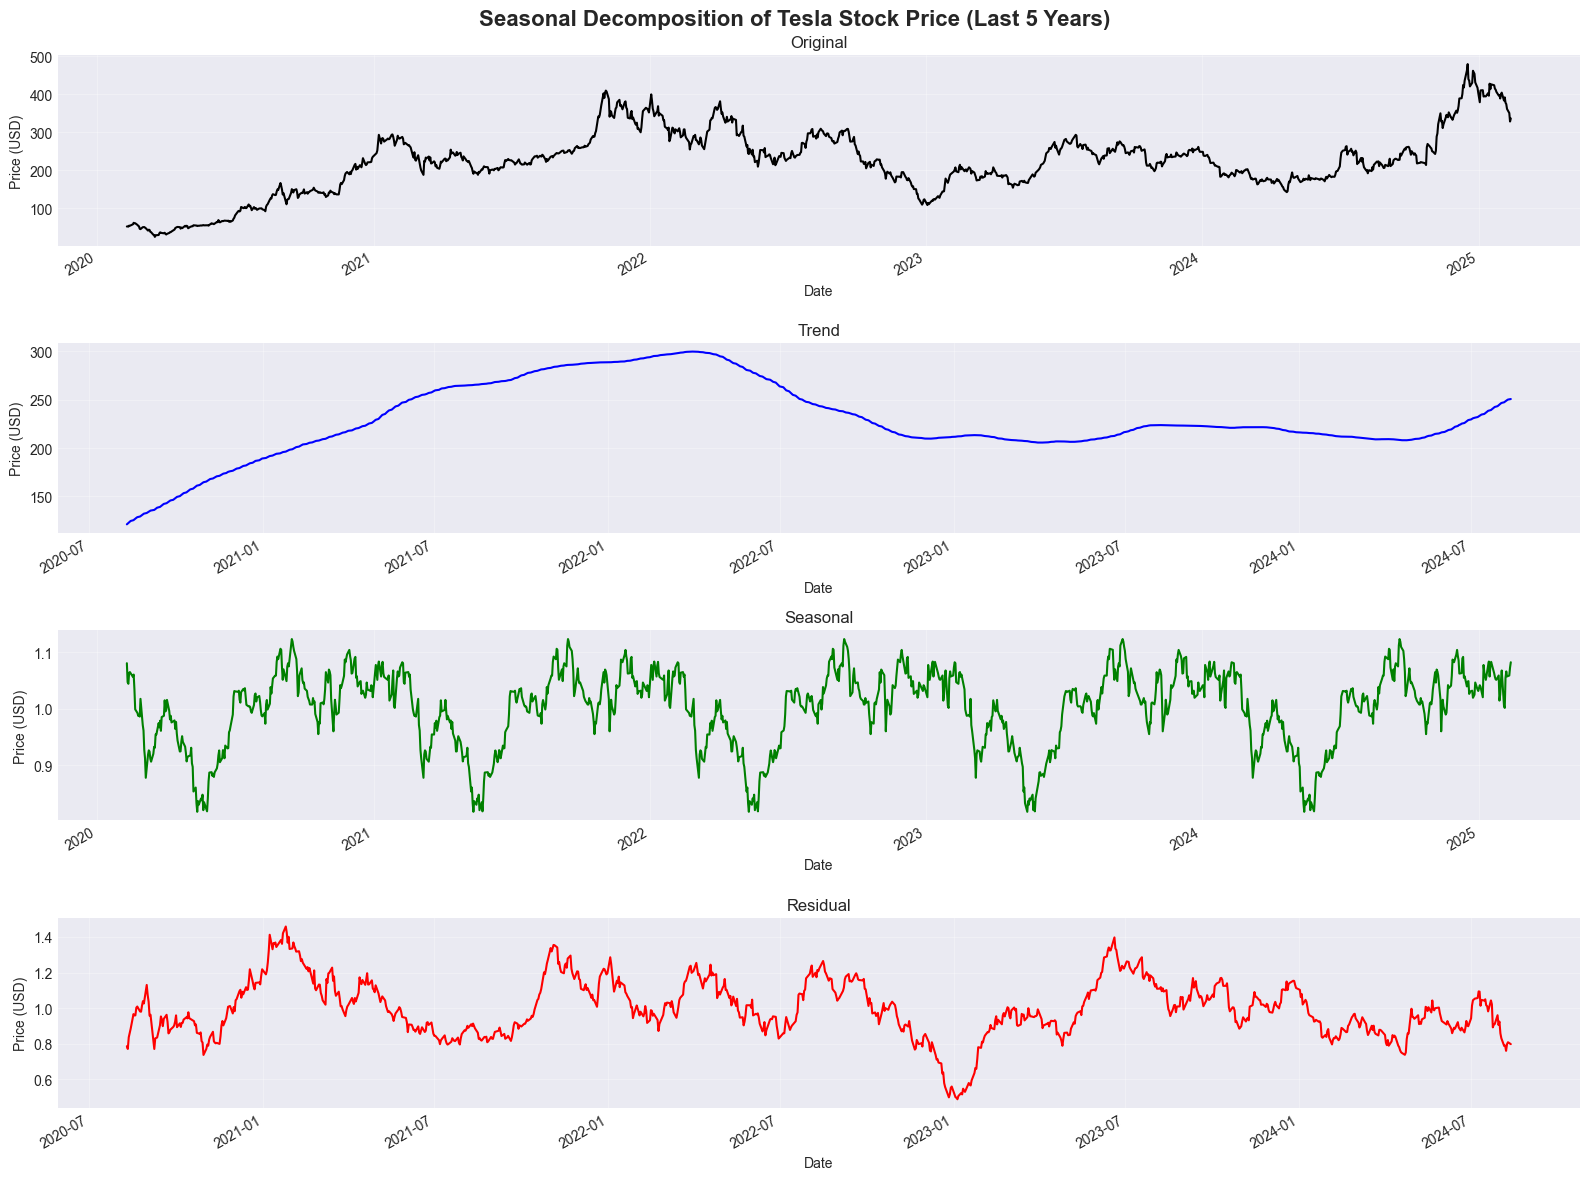

In [30]:
# Graph 22: Seasonal Decomposition of Close Price
from statsmodels.tsa.seasonal import seasonal_decompose

# Use last 5 years for decomposition
decompose_data = df['Close'].tail(1260)  # ~5 years of trading days
decomposition = seasonal_decompose(decompose_data, model='multiplicative', period=252)  # 252 trading days = 1 year

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
fig.suptitle('Seasonal Decomposition of Tesla Stock Price (Last 5 Years)', fontsize=16, fontweight='bold')

decomposition.observed.plot(ax=axes[0], title='Original', color='black', linewidth=1.5)
decomposition.trend.plot(ax=axes[1], title='Trend', color='blue', linewidth=1.5)
decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='green', linewidth=1.5)
decomposition.resid.plot(ax=axes[3], title='Residual', color='red', linewidth=1.5)

for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('Price (USD)', fontsize=10)

plt.tight_layout()
plt.show()


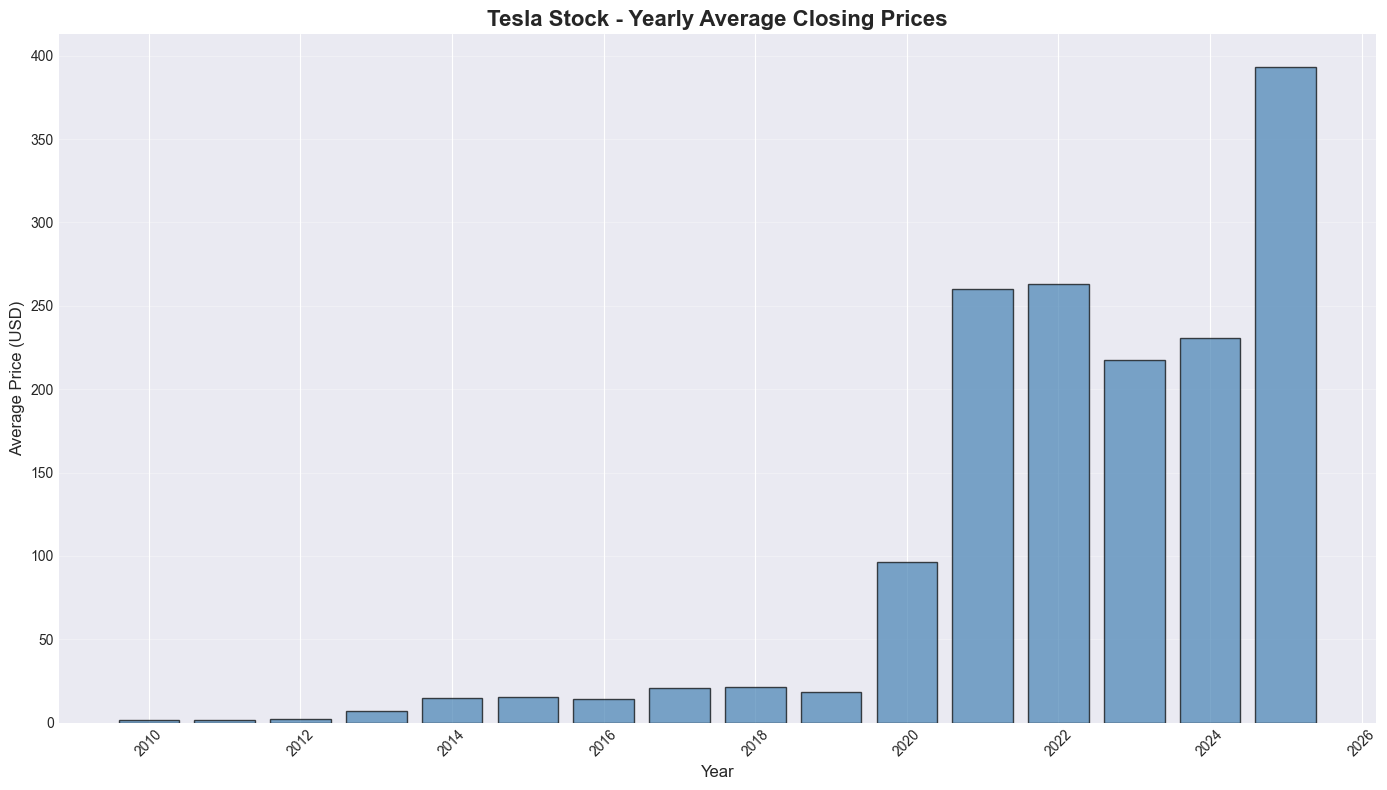

Yearly Average Prices:
Year
2010      1.556123
2011      1.786984
2012      2.077907
2013      6.960082
2014     14.888606
2015     15.336193
2016     13.984484
2017     20.954420
2018     21.153995
2019     18.235347
2020     96.665689
2021    259.998162
2022    263.093081
2023    217.475240
2024    230.614961
2025    393.075713
Name: Close, dtype: float64


In [31]:
# Graph 23: Yearly Average Prices
yearly_avg = df.groupby('Year')['Close'].mean()

plt.figure(figsize=(14, 8))
plt.bar(yearly_avg.index, yearly_avg.values, color='steelblue', alpha=0.7, edgecolor='black')
plt.title('Tesla Stock - Yearly Average Closing Prices', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Yearly Average Prices:")
print(yearly_avg)


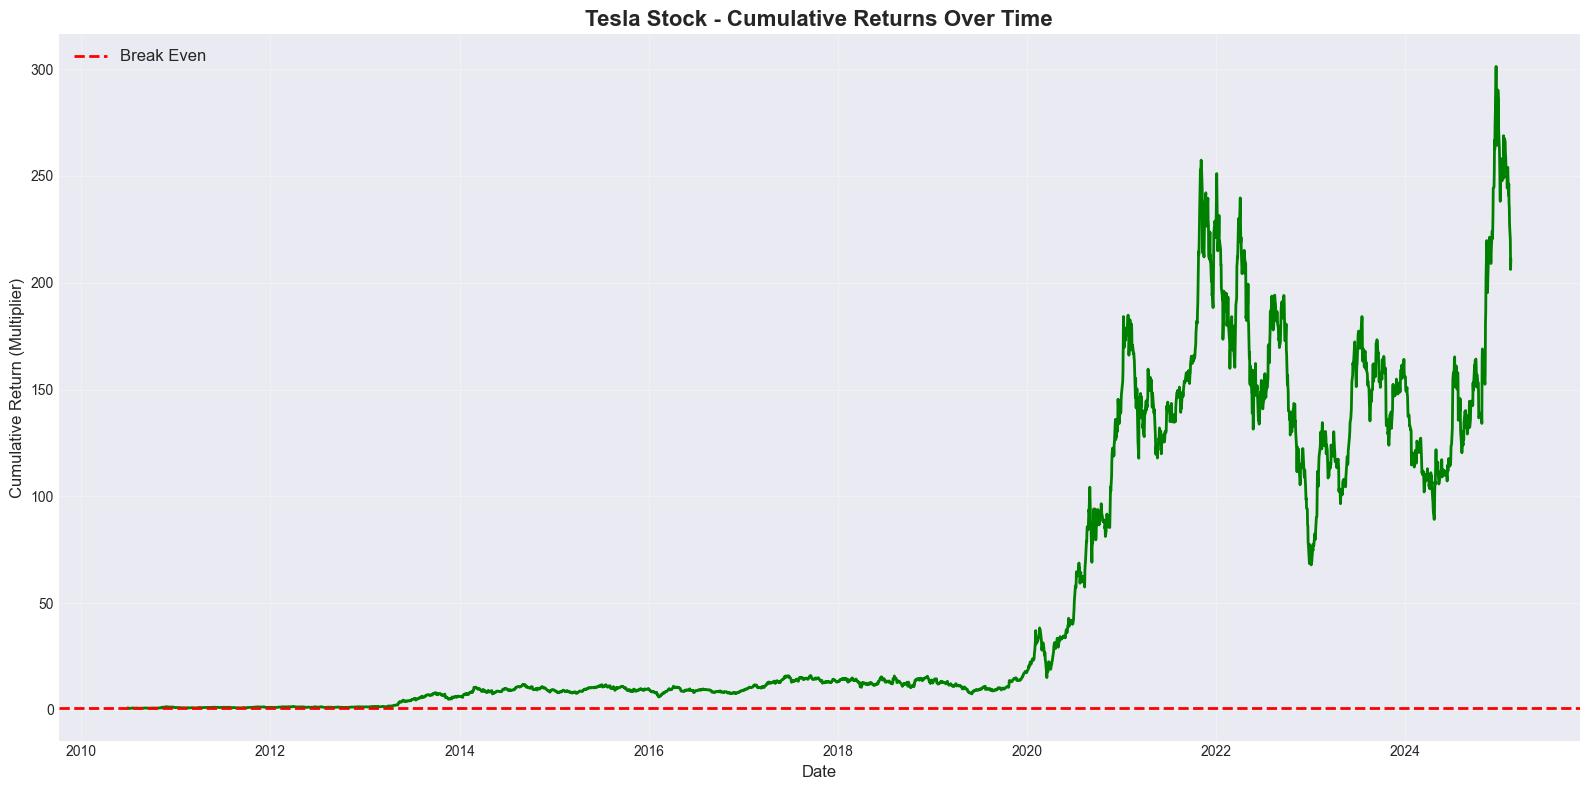

Total Cumulative Return: 21028.71%
If you invested $1 at the start, it would be worth $211.29 now


In [32]:
# Graph 24: Cumulative Returns
df['Cumulative Return'] = (1 + df['Percent Change']/100).cumprod()

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Cumulative Return'], linewidth=2, color='green')
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Break Even')
plt.title('Tesla Stock - Cumulative Returns Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Multiplier)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

final_return = df['Cumulative Return'].iloc[-1]
print(f"Total Cumulative Return: {(final_return - 1) * 100:.2f}%")
print(f"If you invested $1 at the start, it would be worth ${final_return:.2f} now")


## 6. Time Series Analysis and Stationarity Testing


In [33]:
# Augmented Dickey-Fuller Test for Stationarity
adf_result = adfuller(df['Close'].dropna())

print("="*60)
print("AUGMENTED DICKEY-FULLER TEST RESULTS")
print("="*60)
print(f"ADF Statistic: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.6f}")
print(f"Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.6f}")

if adf_result[1] <= 0.05:
    print("\nResult: Series is STATIONARY (p-value <= 0.05)")
else:
    print("\nResult: Series is NON-STATIONARY (p-value > 0.05)")
    print("Differencing may be required for time series models.")


AUGMENTED DICKEY-FULLER TEST RESULTS
ADF Statistic: -0.834274
p-value: 0.808846
Critical Values:
  1%: -3.432142
  5%: -2.862332
  10%: -2.567192

Result: Series is NON-STATIONARY (p-value > 0.05)
Differencing may be required for time series models.


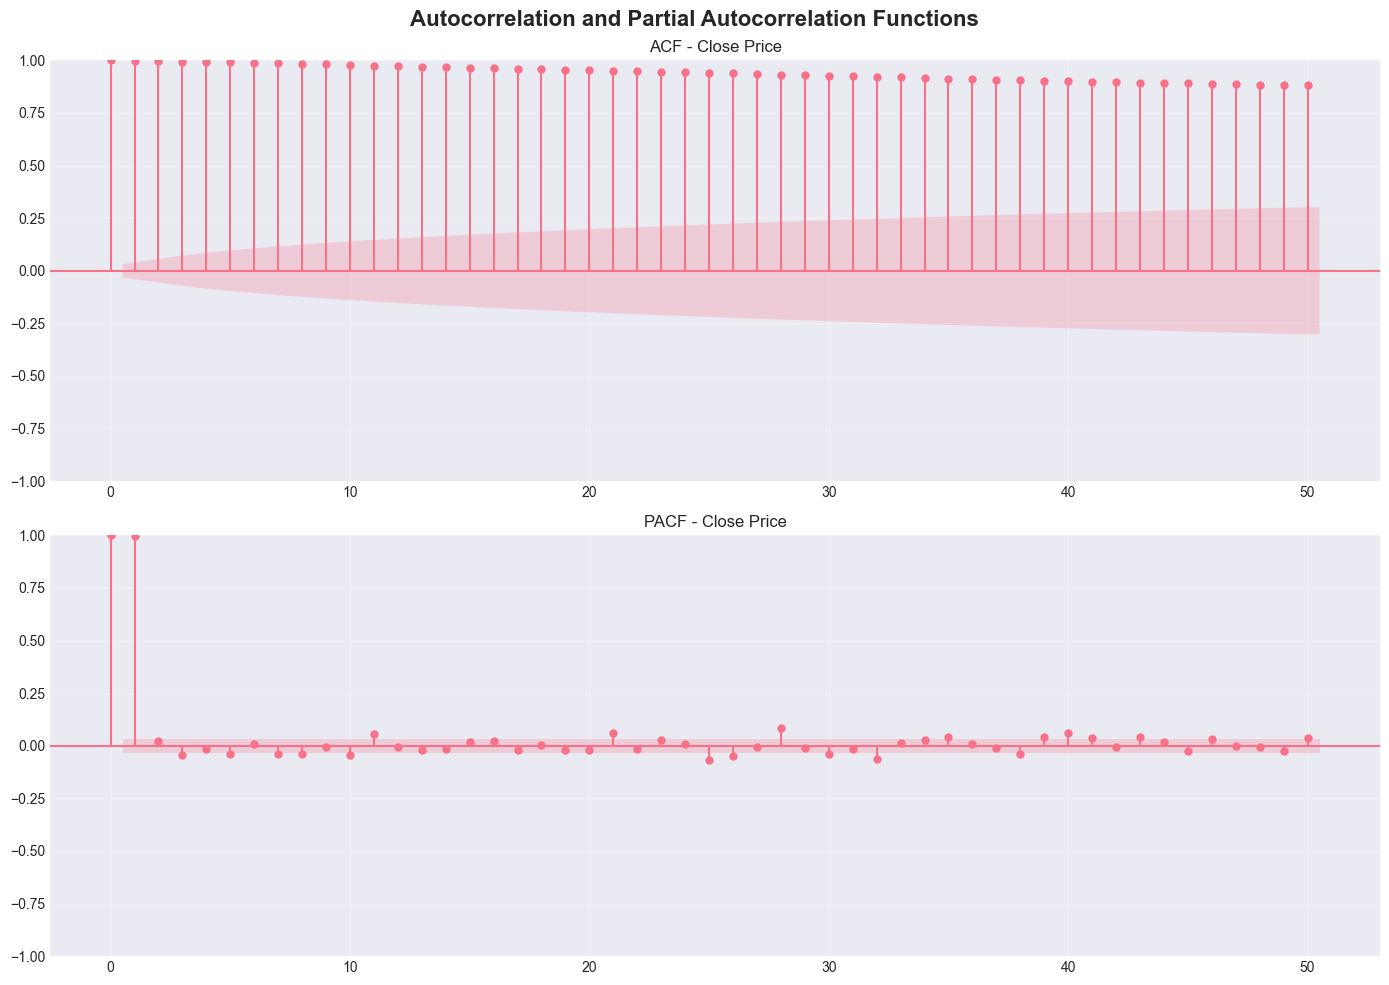

In [34]:
# Graph 25: ACF and PACF Plots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Autocorrelation and Partial Autocorrelation Functions', fontsize=16, fontweight='bold')

plot_acf(df['Close'].dropna(), lags=50, ax=axes[0], title='ACF - Close Price')
plot_pacf(df['Close'].dropna(), lags=50, ax=axes[1], title='PACF - Close Price')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [35]:
# Prepare data for LSTM
if not TENSORFLOW_AVAILABLE:
    print("⚠️  TensorFlow is not available. Skipping LSTM model training.")
    print("   To enable LSTM forecasting, please install TensorFlow:")
    print("   - Run: pip install tensorflow-cpu")
    print("   - Or: pip install tensorflow (if you have GPU support)")
    print("\n   You can still complete all other analyses (Questions 1-5) without TensorFlow.")
else:
    # Use Close price for prediction
    data = df[['Close']].values
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    print(f"Original data shape: {data.shape}")
    print(f"Scaled data shape: {scaled_data.shape}")
    print(f"Scaled data range: [{scaled_data.min():.4f}, {scaled_data.max():.4f}]")


Original data shape: (3680, 1)
Scaled data shape: (3680, 1)
Scaled data range: [0.0000, 1.0000]


In [36]:
# Create sequences for LSTM
if TENSORFLOW_AVAILABLE:
    def create_sequences(data, seq_length=60):
        X, y = [], []
        for i in range(seq_length, len(data)):
            X.append(data[i-seq_length:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)
    
    # Use 60 days of historical data to predict next day
    sequence_length = 60
    X, y = create_sequences(scaled_data, sequence_length)
    
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
else:
    print("Skipping sequence creation (TensorFlow not available)")


X shape: (3620, 60)
y shape: (3620,)


In [37]:
# Reshape X for LSTM (samples, timesteps, features)
if TENSORFLOW_AVAILABLE:
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Split data into train and test sets (80-20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
else:
    print("Skipping data splitting (TensorFlow not available)")


Training set size: 2896
Test set size: 724
X_train shape: (2896, 60, 1)
X_test shape: (724, 60, 1)


### Build and Train LSTM Model


In [38]:
# Build LSTM Model
if TENSORFLOW_AVAILABLE:
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    print("LSTM Model Architecture:")
    model.summary()
else:
    print("Skipping model building (TensorFlow not available)")
    model = None


LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Train the model
if TENSORFLOW_AVAILABLE and model is not None:
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    print("Model training completed!")
else:
    print("Skipping model training (TensorFlow not available)")
    history = None


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 0.0033 - mae: 0.0278 - val_loss: 0.0037 - val_mae: 0.0450
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0013 - mae: 0.0183 - val_loss: 0.0039 - val_mae: 0.0492
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 8.5294e-04 - mae: 0.0146 - val_loss: 0.0088 - val_mae: 0.0754
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 7.9553e-04 - mae: 0.0135 - val_loss: 0.0031 - val_mae: 0.0432
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 8.7667e-04 - mae: 0.0138 - val_loss: 0.0026 - val_mae: 0.0379
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 8.2067e-04 - mae: 0.0147 - val_loss: 0.0026 - val_mae: 0.0384
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 8.2139e-04 - mae: 0.0138 - val_loss: 0.0047 - val_mae: 0.0525
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 8.0098e-04 - mae: 0.0145 - val_loss: 0.0022 - val_mae: 0.0350
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━

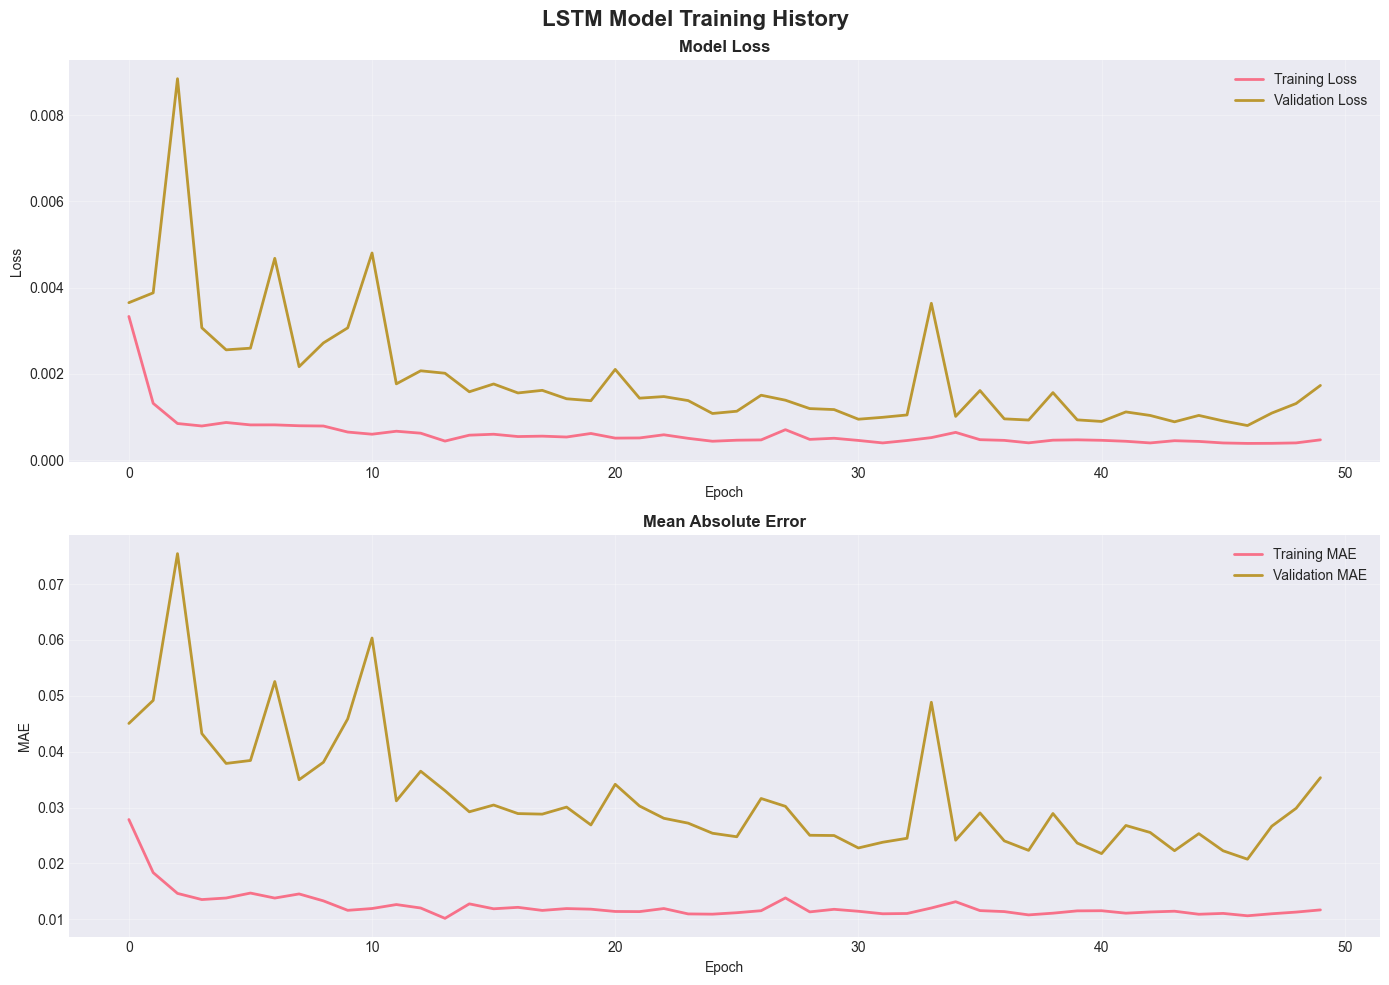

In [41]:
# Graph 26: Training History
if TENSORFLOW_AVAILABLE and history is not None:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle('LSTM Model Training History', fontsize=16, fontweight='bold')
    
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=10)
    axes[0].set_ylabel('Loss', fontsize=10)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_title('Mean Absolute Error', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=10)
    axes[1].set_ylabel('MAE', fontsize=10)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping training history plot (TensorFlow not available)")


### Make Predictions and Evaluate Model


In [42]:
# Make predictions and evaluate model
if TENSORFLOW_AVAILABLE and 'model' in globals() and model is not None:
    train_predictions = model.predict(X_train, verbose=0)
    test_predictions = model.predict(X_test, verbose=0)
    
    # Inverse transform to get actual prices
    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
    train_mae = mean_absolute_error(y_train_actual, train_predictions)
    test_mae = mean_absolute_error(y_test_actual, test_predictions)
    train_r2 = r2_score(y_train_actual, train_predictions)
    test_r2 = r2_score(y_test_actual, test_predictions)
    
    print("="*60)
    print("LSTM MODEL EVALUATION METRICS")
    print("="*60)
    print(f"\nTraining Set:")
    print(f"  RMSE: ${train_rmse:.2f}")
    print(f"  MAE: ${train_mae:.2f}")
    print(f"  R² Score: {train_r2:.4f}")
    
    print(f"\nTest Set:")
    print(f"  RMSE: ${test_rmse:.2f}")
    print(f"  MAE: ${test_mae:.2f}")
    print(f"  R² Score: {test_r2:.4f}")
    
    print(f"\nMean Actual Price: ${y_test_actual.mean():.2f}")
    print(f"RMSE as % of Mean: {(test_rmse / y_test_actual.mean()) * 100:.2f}%")
else:
    print("="*60)
    print("LSTM MODEL EVALUATION - SKIPPED")
    print("="*60)
    print("TensorFlow is not available. LSTM predictions cannot be made.")
    print("\nAlternative: Using ARIMA model for forecasting (see next section)")
    train_predictions = None
    test_predictions = None
    train_rmse = test_rmse = train_mae = test_mae = train_r2 = test_r2 = None


LSTM MODEL EVALUATION METRICS

Training Set:
  RMSE: $5.46
  MAE: $2.74
  R² Score: 0.9958

Test Set:
  RMSE: $13.59
  MAE: $9.94
  R² Score: 0.9578

Mean Actual Price: $237.58
RMSE as % of Mean: 5.72%


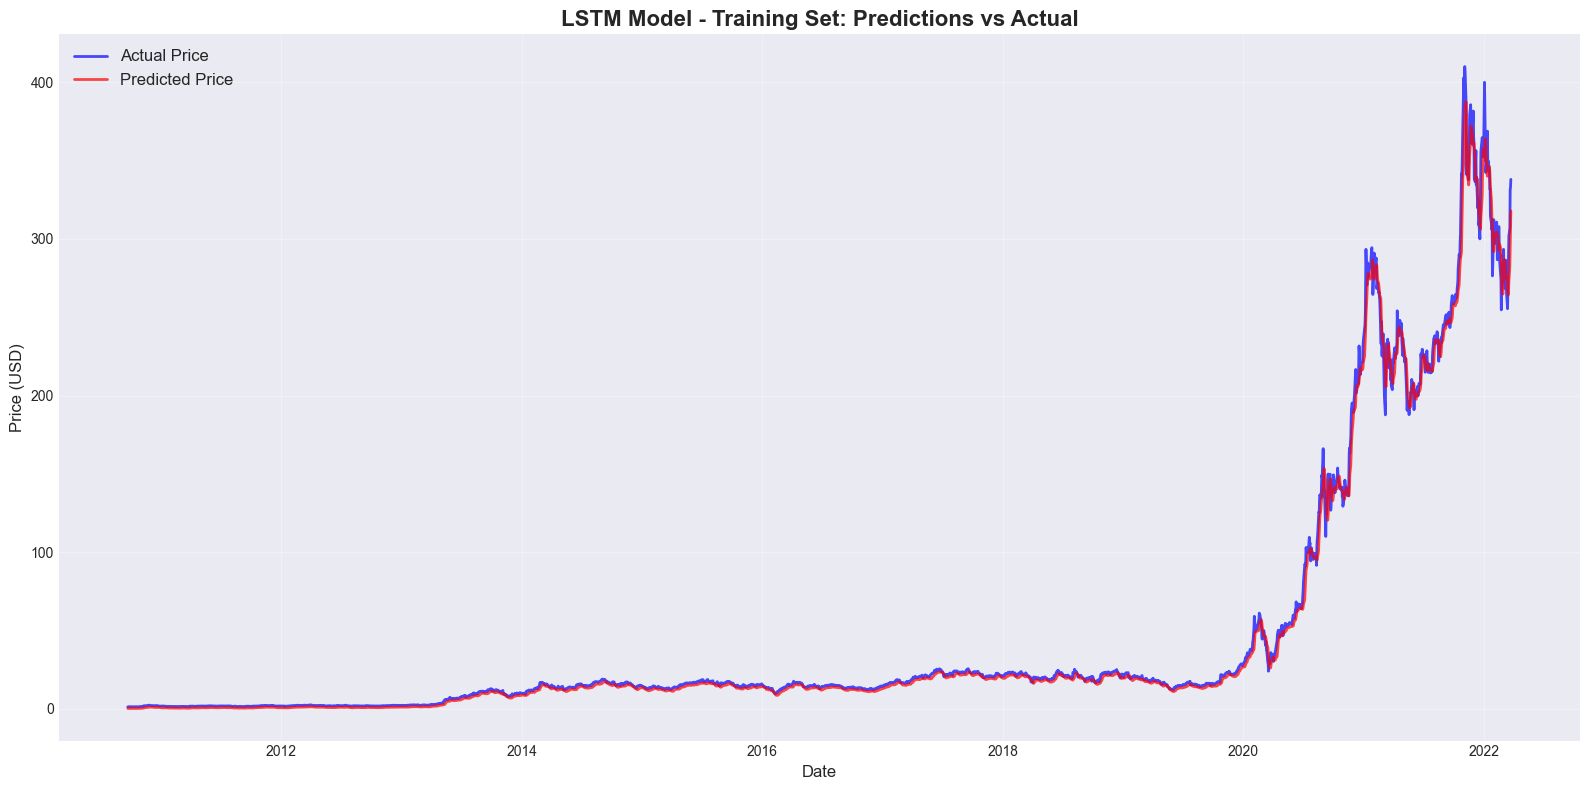

In [43]:
# Graph 27: Predictions vs Actual (Training Set)
if TENSORFLOW_AVAILABLE and train_predictions is not None:
    train_dates = df.index[sequence_length:sequence_length+len(train_predictions)]
    
    plt.figure(figsize=(16, 8))
    plt.plot(train_dates, y_train_actual, label='Actual Price', linewidth=2, color='blue', alpha=0.7)
    plt.plot(train_dates, train_predictions, label='Predicted Price', linewidth=2, color='red', alpha=0.7)
    plt.title('LSTM Model - Training Set: Predictions vs Actual', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping training set predictions plot (TensorFlow not available)")


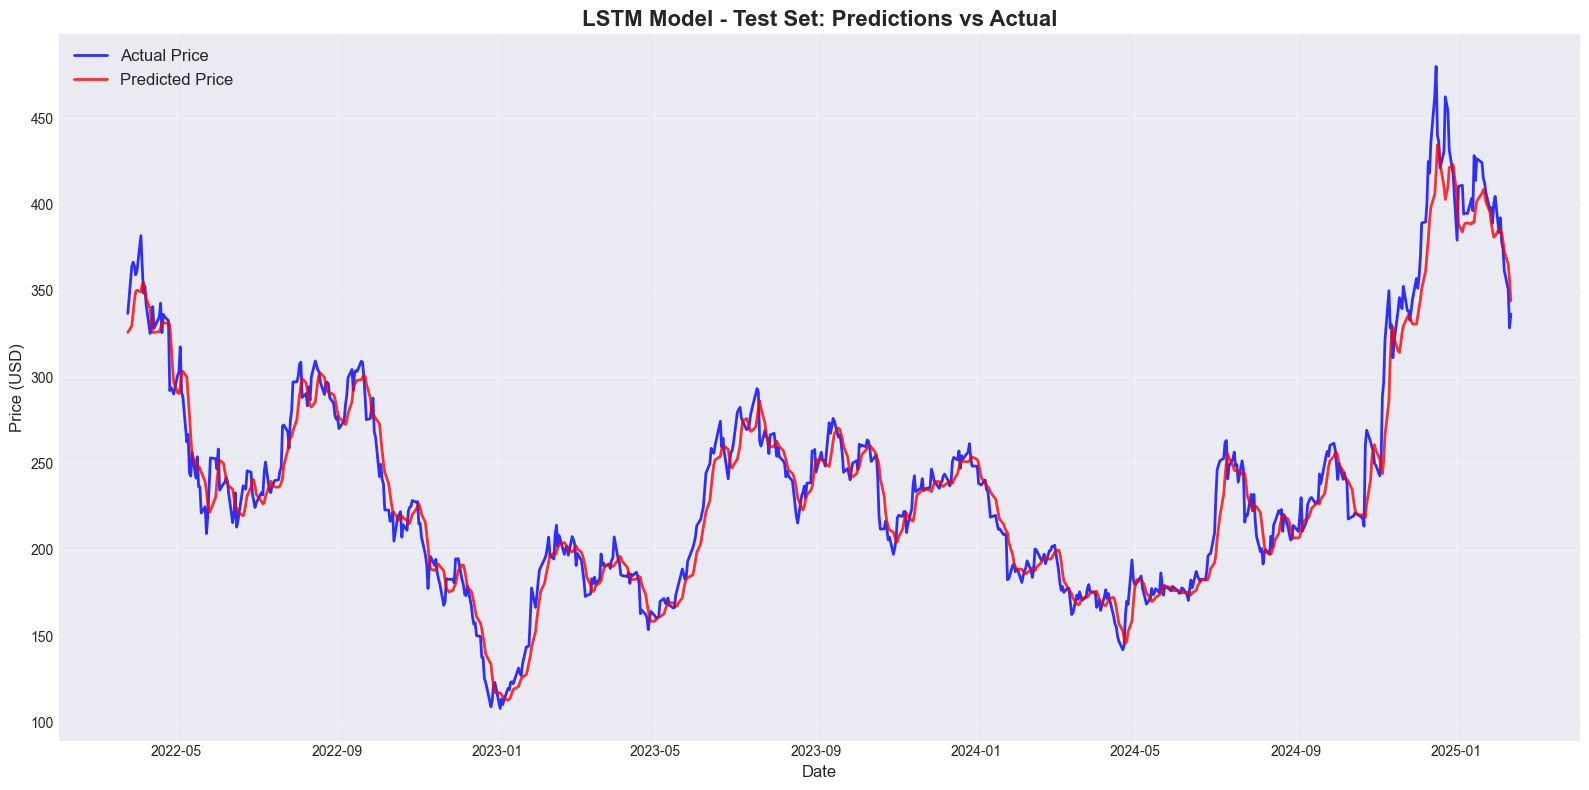

In [44]:
# Graph 28: Predictions vs Actual (Test Set)
if TENSORFLOW_AVAILABLE and test_predictions is not None:
    test_dates = df.index[sequence_length+len(train_predictions):sequence_length+len(train_predictions)+len(test_predictions)]
    
    plt.figure(figsize=(16, 8))
    plt.plot(test_dates, y_test_actual, label='Actual Price', linewidth=2, color='blue', alpha=0.8)
    plt.plot(test_dates, test_predictions, label='Predicted Price', linewidth=2, color='red', alpha=0.8)
    plt.title('LSTM Model - Test Set: Predictions vs Actual', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping test set predictions plot (TensorFlow not available)")


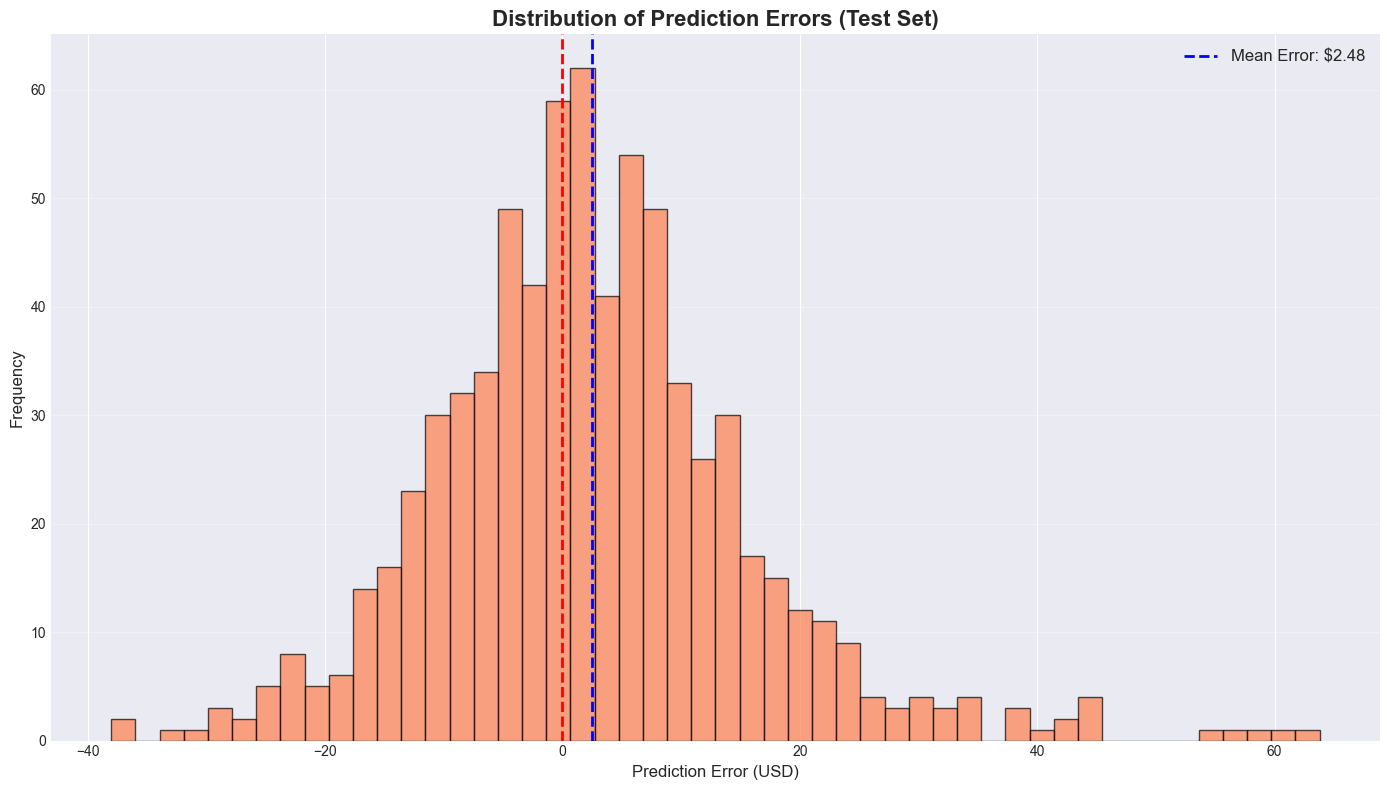

Mean Prediction Error: $2.48
Std Dev of Errors: $13.36


In [45]:
# Graph 29: Prediction Error Distribution
if TENSORFLOW_AVAILABLE and test_predictions is not None:
    prediction_errors = y_test_actual.flatten() - test_predictions.flatten()
    
    plt.figure(figsize=(14, 8))
    plt.hist(prediction_errors, bins=50, color='coral', edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
    plt.axvline(x=prediction_errors.mean(), color='blue', linestyle='--', linewidth=2, 
                label=f'Mean Error: ${prediction_errors.mean():.2f}')
    plt.title('Distribution of Prediction Errors (Test Set)', fontsize=16, fontweight='bold')
    plt.xlabel('Prediction Error (USD)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print(f"Mean Prediction Error: ${prediction_errors.mean():.2f}")
    print(f"Std Dev of Errors: ${prediction_errors.std():.2f}")
else:
    print("Skipping prediction error distribution plot (TensorFlow not available)")


### Future Price Forecasting


In [46]:
# Forecast future prices (next 30 days)
if TENSORFLOW_AVAILABLE and 'model' in globals() and model is not None:
    def forecast_future(model, last_sequence, scaler, days=30):
        """
        Forecast future stock prices using the trained LSTM model
        """
        forecasts = []
        current_sequence = last_sequence.copy()
        
        for _ in range(days):
            # Reshape for prediction
            current_input = current_sequence.reshape(1, sequence_length, 1)
            
            # Predict next day
            next_pred = model.predict(current_input, verbose=0)
            forecasts.append(next_pred[0, 0])
            
            # Update sequence (remove first, add prediction)
            current_sequence = np.append(current_sequence[1:], next_pred[0, 0])
        
        # Inverse transform
        forecasts = np.array(forecasts).reshape(-1, 1)
        forecasts = scaler.inverse_transform(forecasts)
        
        return forecasts.flatten()
    
    # Get last sequence from test set
    last_sequence = scaled_data[-sequence_length:]
    
    # Forecast next 30 days
    future_days = 30
    future_predictions = forecast_future(model, last_sequence, scaler, days=future_days)
    
    # Create future dates
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='B')  # Business days
    
    print(f"Forecasting {future_days} days into the future using LSTM...")
    print(f"Last known price: ${df['Close'].iloc[-1]:.2f}")
    print(f"\nNext {future_days} days forecast:")
    for i, (date, price) in enumerate(zip(future_dates, future_predictions), 1):
        print(f"Day {i} ({date.strftime('%Y-%m-%d')}): ${price:.2f}")
else:
    # Alternative: Use ARIMA for forecasting
    print("="*60)
    print("ALTERNATIVE FORECASTING: Using ARIMA Model")
    print("="*60)
    print("TensorFlow is not available. Using ARIMA model for forecasting instead.")
    
    # Prepare data for ARIMA
    train_size = int(len(df) * 0.8)
    train_data = df['Close'].iloc[:train_size]
    test_data = df['Close'].iloc[train_size:]
    
    # Fit ARIMA model
    print("\nFitting ARIMA model...")
    try:
        arima_model = ARIMA(train_data, order=(5, 1, 0))
        arima_fitted = arima_model.fit()
        
        # Forecast next 30 days
        future_days = 30
        forecast = arima_fitted.forecast(steps=future_days)
        future_predictions = forecast.values
        
        # Create future dates
        last_date = df.index[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='B')
        
        print(f"\nForecasting {future_days} days into the future using ARIMA...")
        print(f"Last known price: ${df['Close'].iloc[-1]:.2f}")
        print(f"\nNext {future_days} days forecast:")
        for i, (date, price) in enumerate(zip(future_dates, future_predictions), 1):
            print(f"Day {i} ({date.strftime('%Y-%m-%d')}): ${price:.2f}")
            
        print(f"\nARIMA Model Summary:")
        print(arima_fitted.summary())
        
    except Exception as e:
        print(f"Error fitting ARIMA model: {e}")
        print("Using simple trend-based forecast instead...")
        # Simple trend forecast
        recent_trend = df['Close'].iloc[-30:].pct_change().mean()
        last_price = df['Close'].iloc[-1]
        future_days = 30
        future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_days, freq='B')
        future_predictions = [last_price * (1 + recent_trend) ** (i+1) for i in range(future_days)]
        
        print(f"\nSimple trend-based forecast ({future_days} days):")
        for i, (date, price) in enumerate(zip(future_dates, future_predictions), 1):
            print(f"Day {i} ({date.strftime('%Y-%m-%d')}): ${price:.2f}")


Forecasting 30 days into the future using LSTM...
Last known price: $336.51

Next 30 days forecast:
Day 1 (2025-02-13): $335.85
Day 2 (2025-02-14): $331.98
Day 3 (2025-02-17): $330.57
Day 4 (2025-02-18): $330.30
Day 5 (2025-02-19): $330.38
Day 6 (2025-02-20): $330.41
Day 7 (2025-02-21): $330.17
Day 8 (2025-02-24): $329.56
Day 9 (2025-02-25): $328.58
Day 10 (2025-02-26): $327.26
Day 11 (2025-02-27): $325.68
Day 12 (2025-02-28): $323.91
Day 13 (2025-03-03): $322.05
Day 14 (2025-03-04): $320.16
Day 15 (2025-03-05): $318.30
Day 16 (2025-03-06): $316.51
Day 17 (2025-03-07): $314.81
Day 18 (2025-03-10): $313.20
Day 19 (2025-03-11): $311.70
Day 20 (2025-03-12): $310.28
Day 21 (2025-03-13): $308.93
Day 22 (2025-03-14): $307.64
Day 23 (2025-03-17): $306.40
Day 24 (2025-03-18): $305.20
Day 25 (2025-03-19): $304.02
Day 26 (2025-03-20): $302.86
Day 27 (2025-03-21): $301.71
Day 28 (2025-03-24): $300.57
Day 29 (2025-03-25): $299.45
Day 30 (2025-03-26): $298.34


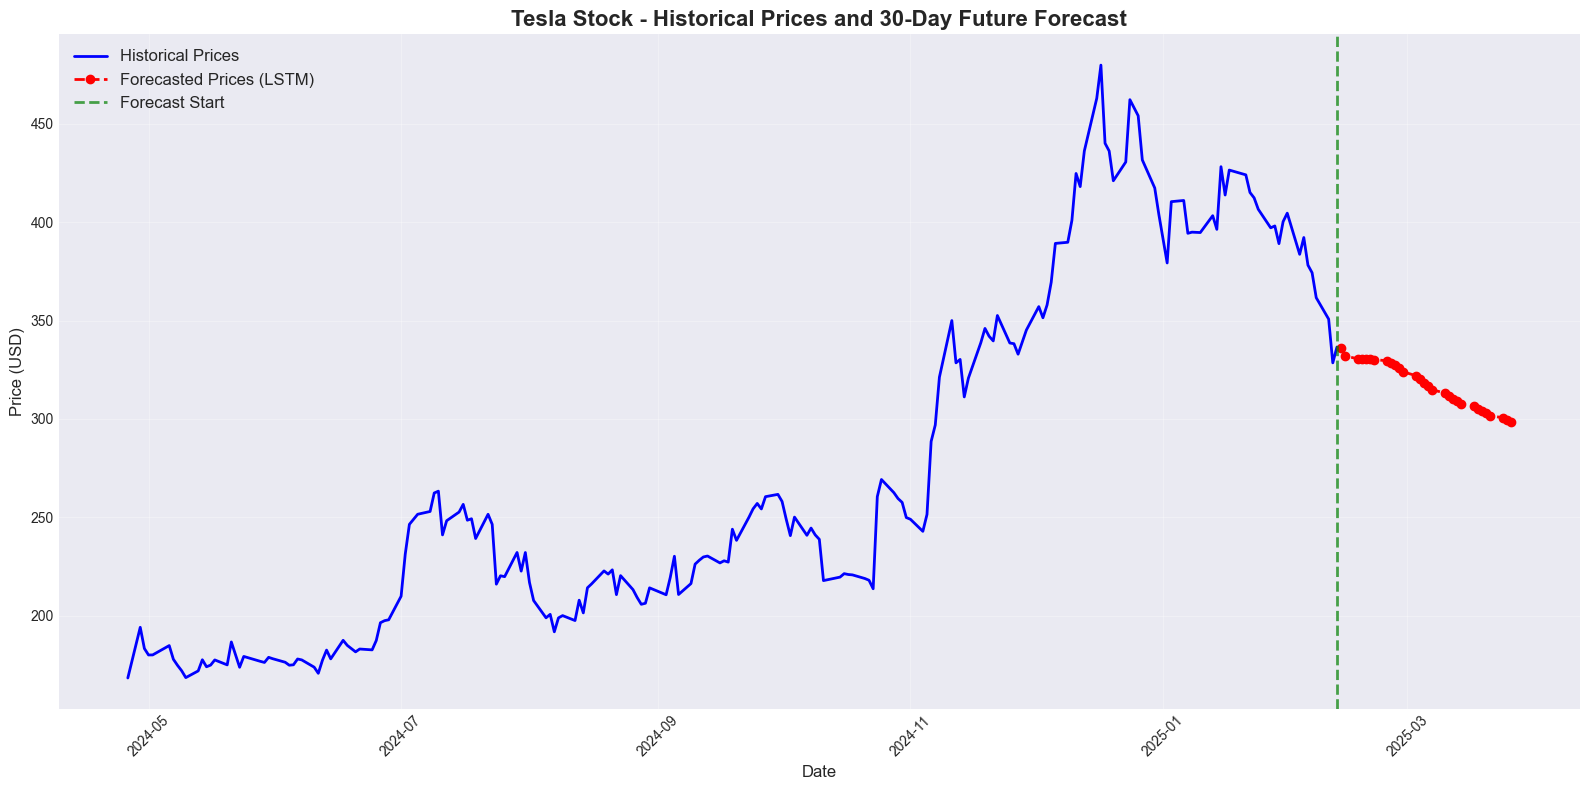


Forecast Summary:
  Current Price: $336.51
  Forecasted Price (Day 30): $298.34
  Expected Change: $-38.17
  Expected % Change: -11.34%


In [47]:
# Graph 30: Future Price Forecast
if 'future_predictions' in locals() and future_predictions is not None:
    fig = plt.figure(figsize=(16, 8))
    
    # Plot historical data (last 200 days)
    historical_days = 200
    historical_dates = df.index[-historical_days:]
    historical_prices = df['Close'].iloc[-historical_days:]
    
    forecast_label = 'Forecasted Prices (LSTM)' if TENSORFLOW_AVAILABLE else 'Forecasted Prices (ARIMA)'
    
    plt.plot(historical_dates, historical_prices, label='Historical Prices', linewidth=2, color='blue')
    plt.plot(future_dates, future_predictions, label=forecast_label, linewidth=2, color='red', linestyle='--', marker='o')
    plt.axvline(x=df.index[-1], color='green', linestyle='--', linewidth=2, alpha=0.7, label='Forecast Start')
    
    plt.title(f'Tesla Stock - Historical Prices and {len(future_predictions)}-Day Future Forecast', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\nForecast Summary:")
    print(f"  Current Price: ${df['Close'].iloc[-1]:.2f}")
    print(f"  Forecasted Price (Day {len(future_predictions)}): ${future_predictions[-1]:.2f}")
    print(f"  Expected Change: ${future_predictions[-1] - df['Close'].iloc[-1]:.2f}")
    print(f"  Expected % Change: {((future_predictions[-1] / df['Close'].iloc[-1]) - 1) * 100:.2f}%")
else:
    print("Skipping forecast plot (forecasting not available)")


## 8. Summary and Conclusions


In [48]:
print("="*60)
print("TESLA STOCK ANALYSIS - SUMMARY")
print("="*60)

print("\n1. PRICE CHANGE OVER TIME:")
print(f"   Initial Price (2010): ${df['Close'].iloc[0]:.2f}")
print(f"   Final Price (2025): ${df['Close'].iloc[-1]:.2f}")
print(f"   Total Return: {((df['Close'].iloc[-1] / df['Close'].iloc[0]) - 1) * 100:.2f}%")

print("\n2. DAILY RETURN STATISTICS:")
print(f"   Average Daily Return: {df['Daily Return'].mean():.4f}%")
print(f"   Standard Deviation: {df['Daily Return'].std():.4f}%")
print(f"   Maximum Daily Return: {df['Daily Return'].max():.4f}%")
print(f"   Minimum Daily Return: {df['Daily Return'].min():.4f}%")

print("\n3. MOVING AVERAGES:")
print(f"   Current MA 50: ${df['MA_50'].iloc[-1]:.2f}")
print(f"   Current MA 200: ${df['MA_200'].iloc[-1]:.2f}")
print(f"   Price vs MA 50: {'Above' if df['Close'].iloc[-1] > df['MA_50'].iloc[-1] else 'Below'}")
print(f"   Price vs MA 200: {'Above' if df['Close'].iloc[-1] > df['MA_200'].iloc[-1] else 'Below'}")

print("\n4. CORRELATION ANALYSIS:")
print(f"   Open-Close Correlation: {df['Open'].corr(df['Close']):.4f}")
print(f"   Volume-Close Correlation: {df['Volume'].corr(df['Close']):.4f}")

print("\n5. RISK METRICS:")
returns = df['Percent Change'].dropna()
VaR_95 = np.percentile(returns, 5)
sharpe = (df['Percent Change'].mean() / df['Percent Change'].std()) * np.sqrt(252)
print(f"   Value at Risk (95%): {VaR_95:.2f}%")
print(f"   Annualized Sharpe Ratio: {sharpe:.4f}")
print(f"   Maximum Drawdown: {df['Drawdown'].min():.2f}%")

print("\n6. FORECASTING MODEL:")
if TENSORFLOW_AVAILABLE and test_rmse is not None:
    print("   Model Type: LSTM (Long Short-Term Memory)")
    print(f"   Test RMSE: ${test_rmse:.2f}")
    print(f"   Test MAE: ${test_mae:.2f}")
    print(f"   Test R² Score: {test_r2:.4f}")
    if 'future_predictions' in locals() and future_predictions is not None:
        print(f"   Forecasted Price (30 days): ${future_predictions[-1]:.2f}")
else:
    print("   Model Type: ARIMA (Alternative - TensorFlow not available)")
    if 'future_predictions' in locals() and future_predictions is not None:
        print(f"   Forecasted Price (30 days): ${future_predictions[-1]:.2f}")
    else:
        print("   Forecast: Not available")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)


TESLA STOCK ANALYSIS - SUMMARY

1. PRICE CHANGE OVER TIME:
   Initial Price (2010): $1.59
   Final Price (2025): $336.51
   Total Return: 21028.71%

2. DAILY RETURN STATISTICS:
   Average Daily Return: 0.0281%
   Standard Deviation: 2.9426%
   Maximum Daily Return: 25.7368%
   Minimum Daily Return: -19.7535%

3. MOVING AVERAGES:
   Current MA 50: $401.73
   Current MA 200: $270.50
   Price vs MA 50: Below
   Price vs MA 200: Above

4. CORRELATION ANALYSIS:
   Open-Close Correlation: 0.9992
   Volume-Close Correlation: 0.0861

5. RISK METRICS:
   Value at Risk (95%): -5.12%
   Annualized Sharpe Ratio: 0.9245
   Maximum Drawdown: -73.63%

6. FORECASTING MODEL:
   Model Type: LSTM (Long Short-Term Memory)
   Test RMSE: $13.59
   Test MAE: $9.94
   Test R² Score: 0.9578
   Forecasted Price (30 days): $298.34

ANALYSIS COMPLETE
